<a href="https://colab.research.google.com/github/Nyon0k/MVP-Machine-Learning---Especializacao-Ciencia-de-Dados-e-Analytics---PUCRJ/blob/main/ml_sprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gerador da Base de Dados Fictícia

In [ ]:
# -*- coding: utf-8 -*-
"""
Gera base sintética de risco de crédito em Parquet com campos de PD/PE:
- Campos adicionados: ead, lgd, valor_recuperado, pd_true, pd_model
- Salva em Parquet (requer pyarrow)
"""

import numpy as np
import pandas as pd
from datetime import datetime

# =========================
# PARÂMETROS
# =========================
N = 1_000_000                # nº de linhas
SEED = 42
TARGET_DEFAULT_RATE = 0.12   # taxa alvo global de default (calibração da pd_true)
OUT_PARQUET = "dados_ficticios_risco_credito.parquet"

np.random.seed(SEED)

# =========================
# HELPERS
# =========================
def random_dates(n, start, end):
    delta_days = (end - start).days
    return pd.to_datetime(start) + pd.to_timedelta(
        np.random.randint(0, delta_days + 1, n), unit="D"
    )

def logistic(z):
    return 1 / (1 + np.exp(-z))

def annuity_payment(principal, monthly_rate, months):
    mr = monthly_rate
    with np.errstate(divide='ignore', invalid='ignore'):
        num = principal * mr * (1 + mr) ** months
        den = (1 + mr) ** months - 1
        pmt = np.where(np.isclose(mr, 0), principal / months, num / den)
    return np.clip(pmt, 0, None)

# =========================
# GERAÇÃO DA BASE
# =========================
start_date = pd.Timestamp("2018-01-01")
end_date   = pd.Timestamp("2026-07-31")

ufs = np.array(["SP","RJ","MG","RS","BA","PE","PR","SC","GO","DF"])
regiao_map = {
    "SP": "Sudeste", "RJ": "Sudeste", "MG": "Sudeste",
    "RS": "Sul", "PR": "Sul", "SC": "Sul",
    "BA": "Nordeste", "PE": "Nordeste",
    "GO": "Centro-Oeste", "DF": "Centro-Oeste",
}
canais = np.array(["Agência","App","Internet Banking","Correspondente"])
produtos = np.array(["Pessoal","Consignado","Veículo","Cartão","Home_Equity"])
escolaridade = np.array(["Fundamental","Médio","Superior","Pós"])
estado_civil = np.array(["Solteiro","Casado","Divorciado","Viúvo"])
vinculo_emprego = np.array(["CLT","Servidor","Autônomo","Empresário","Desempregado"])
setores = np.array(["Serviços","Indústria","Comércio","TI","Saúde","Educação","Construção"])

df = pd.DataFrame({
    "id_cliente": np.arange(1, N+1, dtype=np.int64),
    "data_solicitacao": random_dates(N, start_date, end_date),
    "uf": np.random.choice(ufs, N, p=[0.30,0.12,0.18,0.08,0.08,0.06,0.07,0.05,0.04,0.02]),
})
df["regiao"] = df["uf"].map(regiao_map)

# Demografia e relacionamento
df["idade"] = np.clip(np.random.normal(38, 10, N).round(), 18, 70).astype(int)
tempo_conta = np.random.lognormal(mean=np.log(4.0), sigma=0.7, size=N)
df["tempo_conta_anos"] = np.clip(tempo_conta, 0, 25).round(1)
df["canal"] = np.random.choice(canais, N, p=[0.35,0.30,0.20,0.15])
df["produto"] = np.random.choice(produtos, N, p=[0.45,0.20,0.15,0.15,0.05])
df["escolaridade"] = np.random.choice(escolaridade, N, p=[0.20,0.40,0.30,0.10])
df["estado_civil"] = np.random.choice(estado_civil, N, p=[0.45,0.40,0.12,0.03])
df["vinculo_emprego"] = np.random.choice(vinculo_emprego, N, p=[0.55,0.10,0.20,0.10,0.05])
df["setor"] = np.random.choice(setores, N)

# Uso de serviços
df["usa_internet_banking"] = np.random.rand(N) < np.where(df["canal"].eq("Agência"), 0.45, 0.75)
df["possui_cartao_credito"] = np.random.rand(N) < 0.65
df["possui_investimentos"] = np.random.rand(N) < np.where(df["escolaridade"].isin(["Superior","Pós"]), 0.45, 0.20)
df["possui_seguro"] = np.random.rand(N) < 0.30
df["qtd_produtos_bancarios"] = (
    1
    + df["possui_cartao_credito"].astype(int)
    + df["possui_investimentos"].astype(int)
    + df["possui_seguro"].astype(int)
)

# Renda
mu_base = {"CLT": 9.5, "Servidor": 9.8, "Autônomo": 9.3, "Empresário": 10.1, "Desempregado": 8.5}
sigma_base = 0.55
mu = df["vinculo_emprego"].map(mu_base).astype(float).values
esc_adj = df["escolaridade"].map({"Fundamental":-0.25,"Médio":0.0,"Superior":0.25,"Pós":0.45}).values
mu = mu + esc_adj
renda_atual = np.random.lognormal(mean=mu, sigma=sigma_base, size=N)
renda_atual = np.clip(renda_atual, 500, 60_000)
df["renda_mensal_atual"] = np.round(renda_atual, 2)
eps = np.random.normal(0, 0.08, N)
df["renda_mensal_anterior"] = np.round(df["renda_mensal_atual"] * (0.90 + eps), 2)

# Score + atrasos
base_score = np.clip(np.random.normal(600, 120, N), 300, 900)
lambda_atraso = np.exp(1.2 - (base_score - 600)/250)
df["atrasos_passados"] = np.random.poisson(lambda_atraso).astype(int)
adj_score = (
    base_score
    + 0.0008 * (df["renda_mensal_atual"].values - 4000)
    - 25 * np.clip(df["atrasos_passados"].values, 0, 5)
    + 5 * df["qtd_produtos_bancarios"].values
    + 8 * (df["tempo_conta_anos"].values)
)
df["score_credito"] = np.clip(adj_score, 300, 900).round().astype(int)

# Prazos por produto
prazo_choices = {
    "Pessoal":   [6,12,18,24,36],
    "Consignado":[12,24,36,48,60],
    "Veículo":   [24,36,48,60],
    "Cartão":    [6,12,18,24],
    "Home_Equity":[60,120,180]
}
df["parcelas"] = [np.random.choice(prazo_choices[p]) for p in df["produto"].values]

# Ticket por produto + coerência com renda
ticket_mu = {"Pessoal": 10.0, "Consignado": 10.2, "Veículo": 10.5, "Cartão": 9.2, "Home_Equity": 12.0}
ticket_sigma = {"Pessoal": 0.8, "Consignado": 0.7, "Veículo": 0.7, "Cartão": 0.6, "Home_Equity": 0.9}
valores = np.array([np.random.lognormal(ticket_mu[p], ticket_sigma[p]) for p in df["produto"].values])
multiplicador_renda = np.where(df["produto"].eq("Home_Equity"), 30, 12)
tetos = {"Pessoal": 80_000, "Consignado": 100_000, "Veículo": 200_000, "Cartão": 20_000, "Home_Equity": 1_000_000}
max_por_prod = np.array([tetos[p] for p in df["produto"].values])
upper_cap = np.minimum(max_por_prod, multiplicador_renda * df["renda_mensal_atual"].values)
df["valor_emprestimo"] = np.round(np.clip(valores, 300, upper_cap), 2)

# Juros, parcela e DTI
prod_spread = df["produto"].map({"Pessoal":0.025,"Consignado":0.015,"Veículo":0.018,"Cartão":0.03,"Home_Equity":0.012}).values
score_penalty = np.clip((650 - df["score_credito"].values)/1000, 0, 0.02)
tx_m = prod_spread + score_penalty + np.random.normal(0, 0.002, N)
tx_m = np.clip(tx_m, 0.005, 0.04)
df["taxa_juros_mensal"] = np.round(tx_m, 4)

meses = df["parcelas"].values.astype(int)
prest = annuity_payment(df["valor_emprestimo"].values, df["taxa_juros_mensal"].values, meses)
df["valor_parcela"] = np.round(prest, 2)
df["dti"] = np.round(np.where(df["renda_mensal_atual"]>0, df["valor_parcela"]/df["renda_mensal_atual"], np.nan), 3)

# Transações e histórico
df["frequencia_transacoes"] = np.random.poisson(lam=12 + 6*df["usa_internet_banking"].astype(int) + 3*df["possui_cartao_credito"].astype(int)).astype(int)
df["valor_emprestimos_anteriores"] = np.round(np.random.exponential(8000, N) * (1 + 0.4*df["qtd_produtos_bancarios"].values), 2)

# Drift temporal
months_from_start = (df["data_solicitacao"].values.astype('datetime64[M]') - np.datetime64(start_date, 'M')).astype(int)
time_drift = -0.01 * (months_from_start / months_from_start.max())

# PD verdadeira e rótulo
z = (
    -2.0
    + time_drift
    + 0.00008 * (df["valor_emprestimo"].values - 10_000)
    + 2.2 * np.clip(df["dti"].fillna(df["dti"].median()).values - 0.25, 0, None)
    + 0.45 * (df["atrasos_passados"].values)
    - 0.006 * (df["score_credito"].values - 600)
    - 0.00003 * (df["renda_mensal_atual"].values - 4000)
    - 0.03 * (df["tempo_conta_anos"].values)
    - 0.05 * (df["qtd_produtos_bancarios"].values - 2)
    - 0.12 * df["possui_investimentos"].astype(int).values
    - 0.08 * df["usa_internet_banking"].astype(int).values
)
efeito_prod = {"Pessoal":0.10,"Consignado":-0.25,"Veículo":-0.05,"Cartão":0.20,"Home_Equity":-0.35}
efeito_canal = {"Agência":0.05,"App":-0.05,"Internet Banking":-0.08,"Correspondente":0.12}
efeito_uf = {"SP":-0.05,"RJ":0.06,"MG":-0.02,"RS":0.0,"BA":0.05,"PE":0.05,"PR":-0.01,"SC":-0.02,"GO":0.02,"DF":-0.01}
z += df["produto"].map(efeito_prod).values
z += df["canal"].map(efeito_canal).values
z += df["uf"].map(efeito_uf).values
z += np.random.normal(0, 0.4, N)

p_default = logistic(z)

# calibração global para TARGET_DEFAULT_RATE
actual_rate = p_default.mean()
if 0 < actual_rate < 1:
    adj = np.log(TARGET_DEFAULT_RATE/(1-TARGET_DEFAULT_RATE)) - np.log(actual_rate/(1-actual_rate))
    logit = np.log(p_default/(1 - p_default))
    p_default = logistic(logit + adj)

df["pd_true"] = p_default
df["inadimplente"] = (np.random.rand(N) < p_default).astype(int)

# Risco: EAD, LGD, valor_recuperado
df["ead"] = df["valor_emprestimo"]
lgd_alpha_beta = {
    "Pessoal": (7,3),        # ~0.70
    "Consignado": (3,7),     # ~0.30
    "Veículo": (4.5,5.5),    # ~0.45
    "Cartão": (8.5,1.5),     # ~0.85
    "Home_Equity": (2.5,7.5) # ~0.25
}
alphas = np.array([lgd_alpha_beta[p][0] for p in df["produto"].values])
betas  = np.array([lgd_alpha_beta[p][1] for p in df["produto"].values])
lgd = np.random.beta(alphas, betas)
lgd += df["uf"].map({"RJ":0.02,"BA":0.02,"PE":0.02,"SP":-0.01,"SC":-0.01}).fillna(0).values
lgd += df["canal"].map({"Correspondente":0.02,"Internet Banking":-0.01}).fillna(0).values
lgd = np.clip(lgd, 0.05, 0.95)
df["lgd"] = np.round(lgd, 4)

recuperado = np.zeros(N, dtype=float)
mask_def = df["inadimplente"].values == 1
ruido_rec = np.ones(N)
ruido_rec[mask_def] = np.random.lognormal(mean=-0.05, sigma=0.35, size=mask_def.sum())
recuperado[mask_def] = (1 - df.loc[mask_def, "lgd"].values) * df.loc[mask_def, "ead"].values * ruido_rec[mask_def]
recuperado = np.clip(recuperado, 0, df["ead"].values)
df["valor_recuperado"] = np.round(recuperado, 2)

# pd_model: “modelo” sintético (ruído + leve descalibração)
logit_true = np.log(df["pd_true"].clip(1e-9, 1-1e-9) / (1 - df["pd_true"].clip(1e-9, 1-1e-9)))
noise = np.random.normal(0, 0.5, N)
logit_model = 0.9 * logit_true + 0.2 + noise
df["pd_model"] = logistic(logit_model).clip(1e-6, 1-1e-6)

# Faltantes / outliers leves
mask_no_ib = ~df["usa_internet_banking"]
miss_prob = np.where(mask_no_ib, 0.15, 0.03)
for col in ["renda_mensal_atual","renda_mensal_anterior","tempo_emprego_anos","valor_emprestimos_anteriores"]:
    if col == "tempo_emprego_anos" and col not in df.columns:
        base_te = np.clip(np.random.lognormal(mean=1.2, sigma=0.7, size=N), 0, 40)
        base_te = np.where(df["vinculo_emprego"].eq("Desempregado"), 0, base_te)
        df[col] = np.round(base_te, 1)
    m = (np.random.rand(N) < miss_prob)
    df.loc[m & (np.random.rand(N) < 0.5), col] = np.nan

df.loc[np.random.rand(N) < 0.001, "renda_mensal_atual"] *= 5
df.loc[np.random.rand(N) < 0.001, "valor_emprestimo"] *= 3
df["renda_mensal_atual"] = df["renda_mensal_atual"].clip(0, 120_000).round(2)
df["valor_emprestimo"] = df["valor_emprestimo"].clip(300, 2_000_000).round(2)

# =========================
# SALVAR EM PARQUET
# =========================
try:
    import pyarrow  # noqa: F401
except Exception as e:
    raise RuntimeError("Instale o pacote 'pyarrow' para salvar Parquet: pip install pyarrow") from e

df.to_parquet(OUT_PARQUET, index=False)
print(f"OK! Parquet salvo em: {OUT_PARQUET}\nLinhas: {len(df)} | default_rate: {df['inadimplente'].mean():.4f}")

## Modelagem da Probability Default (PD)

### Leitura da Base Original

In [ ]:
import pandas as pd

# Link compartilhado do Google Drive
url = "https://drive.google.com/file/d/14yuZrUKYQiGhceAF4rYOoQF5G2Mgxx2A/view?usp=sharing"

# Transforma em link de download direto
file_id = url.split("/d/")[1].split("/")[0]
download_url = f"https://drive.google.com/uc?id={file_id}"

# Ler parquet diretamente
df = pd.read_parquet(download_url)
display(df.head())
display(df.columns)

,id_cliente,data_solicitacao,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,...,dti,frequencia_transacoes,valor_emprestimos_anteriores,pd_true,inadimplente,ead,lgd,valor_recuperado,pd_model,tempo_emprego_anos
0,1,2020-05-10,SP,Sudeste,22,12.5,App,Consignado,Médio,Solteiro,...,0.428,27,6505.86,0.972430,1,100000.00,0.3752,60551.22,0.968309,3.7
1,2,2021-07-18,RJ,Sudeste,30,2.4,App,Veículo,Fundamental,Divorciado,...,0.114,21,15534.02,0.786743,1,44847.64,0.3147,41706.49,0.817926,6.3
2,3,2021-02-04,SP,Sudeste,24,5.2,App,Pessoal,Médio,Solteiro,...,0.307,14,38994.06,0.126965,0,12290.31,0.5638,0.00,0.067548,1.6
3,4,2020-12-31,PE,Nordeste,40,3.6,App,Consignado,Médio,Solteiro,...,0.038,18,40463.28,0.312604,0,18890.04,0.1875,0.00,0.388200,1.2
4,5,2026-06-20,PE,Nordeste,35,3.0,Internet Banking,Veículo,Pós,Casado,...,0.084,16,8292.18,0.973499,1,68525.62,0.6273,25505.39,0.973559,5.8


Index(['id_cliente', 'data_solicitacao', 'uf', 'regiao', 'idade',
       'tempo_conta_anos', 'canal', 'produto', 'escolaridade', 'estado_civil',
       'vinculo_emprego', 'setor', 'usa_internet_banking',
       'possui_cartao_credito', 'possui_investimentos', 'possui_seguro',
       'qtd_produtos_bancarios', 'renda_mensal_atual', 'renda_mensal_anterior',
       'atrasos_passados', 'score_credito', 'parcelas', 'valor_emprestimo',
       'taxa_juros_mensal', 'valor_parcela', 'dti', 'frequencia_transacoes',
       'valor_emprestimos_anteriores', 'pd_true', 'inadimplente', 'ead', 'lgd',
       'valor_recuperado', 'pd_model', 'tempo_emprego_anos'],
      dtype='object')

### Preprocessamento da Base

In [ ]:
# Contar valores nulos por coluna
nulos_por_coluna = df.isnull().sum()
total_linhas = len(df)

# Criar DataFrame com quantidade e percentual
nulos_df = pd.DataFrame({
    "Coluna": nulos_por_coluna.index,
    "Qtd_Nulos": nulos_por_coluna.values,
    "Percentual_Nulos": (nulos_por_coluna.values / total_linhas) * 100
})

# Ordenar pelo número de nulos
nulos_df = nulos_df.sort_values(by="Qtd_Nulos", ascending=False)

print(nulos_df)

                          Coluna  Qtd_Nulos  Percentual_Nulos
27  valor_emprestimos_anteriores      36604            3.6604
34            tempo_emprego_anos      36398            3.6398
17            renda_mensal_atual      36361            3.6361
18         renda_mensal_anterior      36096            3.6096
2                             uf          0            0.0000
0                     id_cliente          0            0.0000
1               data_solicitacao          0            0.0000
7                        produto          0            0.0000
8                   escolaridade          0            0.0000
3                         regiao          0            0.0000
4                          idade          0            0.0000
10               vinculo_emprego          0            0.0000
9                   estado_civil          0            0.0000
11                         setor          0            0.0000
12          usa_internet_banking          0            0.0000
14      

* Menos de 5% dos valores sao nulos nas colunas renda_mensal_atual, tempo_emprego_anos, valor_emprestimos_anteriores e renda_mensal_anterior. Iremos seguir com esses valores nulos

In [ ]:
# Contar valores distintos (exclui NaN por padrão)
qtd_distintos = df["data_solicitacao"].unique()

display(qtd_distintos)
print("Valores distintos (sem contar NaN):", qtd_distintos)

<DatetimeArray>
['2020-05-10 00:00:00', '2021-07-18 00:00:00', '2021-02-04 00:00:00',
 '2020-12-31 00:00:00', '2026-06-20 00:00:00', '2022-06-27 00:00:00',
 '2023-12-10 00:00:00', '2019-04-12 00:00:00', '2021-05-23 00:00:00',
 '2018-11-27 00:00:00',
 ...
 '2020-10-07 00:00:00', '2025-02-22 00:00:00', '2020-07-16 00:00:00',
 '2026-07-03 00:00:00', '2026-03-31 00:00:00', '2020-01-07 00:00:00',
 '2026-05-02 00:00:00', '2022-09-27 00:00:00', '2018-09-09 00:00:00',
 '2021-06-15 00:00:00']
Length: 3134, dtype: datetime64[ns]

Valores distintos (sem contar NaN): <DatetimeArray>
['2020-05-10 00:00:00', '2021-07-18 00:00:00', '2021-02-04 00:00:00',
 '2020-12-31 00:00:00', '2026-06-20 00:00:00', '2022-06-27 00:00:00',
 '2023-12-10 00:00:00', '2019-04-12 00:00:00', '2021-05-23 00:00:00',
 '2018-11-27 00:00:00',
 ...
 '2020-10-07 00:00:00', '2025-02-22 00:00:00', '2020-07-16 00:00:00',
 '2026-07-03 00:00:00', '2026-03-31 00:00:00', '2020-01-07 00:00:00',
 '2026-05-02 00:00:00', '2022-09-27 00:00:00', '2018-09-09 00:00:00',
 '2021-06-15 00:00:00']
Length: 3134, dtype: datetime64[ns]


In [ ]:
# Filtrar onde Col2 é nulo
filtro_nulos = df[df["renda_mensal_anterior"].isnull()]

# Contar combinações
resultado = filtro_nulos.groupby("vinculo_emprego").size().reset_index(name="Qtd_Nulos_Col2")

print(resultado)

  vinculo_emprego  Qtd_Nulos_Col2
0        Autônomo            7167
1             CLT           19910
2    Desempregado            1826
3      Empresário            3528
4        Servidor            3665


In [ ]:
# garantir que é datetime
df['data_solicitacao'] = pd.to_datetime(df['data_solicitacao'])

# 1) Em string para exibição: "yyyy-mm"
df['safra'] = df['data_solicitacao'].dt.strftime('%Y-%m')
display(df)

,id_cliente,data_solicitacao,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,...,frequencia_transacoes,valor_emprestimos_anteriores,pd_true,inadimplente,ead,lgd,valor_recuperado,pd_model,tempo_emprego_anos,safra
0,1,2020-05-10,SP,Sudeste,22,12.5,App,Consignado,Médio,Solteiro,...,27,6505.86,0.972430,1,100000.00,0.3752,60551.22,0.968309,3.7,2020-05
1,2,2021-07-18,RJ,Sudeste,30,2.4,App,Veículo,Fundamental,Divorciado,...,21,15534.02,0.786743,1,44847.64,0.3147,41706.49,0.817926,6.3,2021-07
2,3,2021-02-04,SP,Sudeste,24,5.2,App,Pessoal,Médio,Solteiro,...,14,38994.06,0.126965,0,12290.31,0.5638,0.00,0.067548,1.6,2021-02
3,4,2020-12-31,PE,Nordeste,40,3.6,App,Consignado,Médio,Solteiro,...,18,40463.28,0.312604,0,18890.04,0.1875,0.00,0.388200,1.2,2020-12
4,5,2026-06-20,PE,Nordeste,35,3.0,Internet Banking,Veículo,Pós,Casado,...,16,8292.18,0.973499,1,68525.62,0.6273,25505.39,0.973559,5.8,2026-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999996,2019-04-15,BA,Nordeste,46,2.7,Agência,Pessoal,Médio,Viúvo,...,14,10696.75,0.169070,1,14452.78,0.8286,2190.74,0.281351,4.0,2019-04
999996,999997,2025-08-28,RJ,Sudeste,55,7.0,Internet Banking,Consignado,Fundamental,Casado,...,29,4665.41,0.049794,0,16232.34,0.2890,0.00,0.057305,7.3,2025-08
999997,999998,2026-04-13,BA,Nordeste,24,1.5,Internet Banking,Consignado,Pós,Casado,...,17,5331.15,0.313276,1,75421.91,0.2451,51394.05,0.295851,8.8,2026-04
999998,999999,2021-09-14,SP,Sudeste,46,4.6,Agência,Consignado,Médio,Divorciado,...,19,7129.32,0.923616,1,49069.08,0.1477,49069.08,0.921962,1.7,2021-09


In [ ]:
# Contar linhas por safra
qtd_por_safra = (
    df.groupby('safra', dropna=False)  # use dropna=False se quiser incluir NaN
      .size()
      .reset_index(name='qtd')
      .sort_values('safra', ascending=True)
)

safras_distintas = (
    df['safra']
      .drop_duplicates()
      .sort_values()
      .reset_index(drop=True)
)


In [ ]:
# Criando base de treinamento do modelo (Baseline)
inicio = '2021-05'
fim    = '2024-08'

safra_period = pd.PeriodIndex(df['safra'].str[:7], freq='M')
df_baseline = df[(safra_period >= pd.Period(inicio, freq='M')) &
                 (safra_period <= pd.Period(fim,    freq='M'))]

display(df_baseline)

# Criando base de monitoramento e validação
inicio = '2024-08'

safra_period = pd.PeriodIndex(df['safra'].str[:7], freq='M')
df_monitoramento = df[(safra_period > pd.Period(inicio, freq='M'))]

display(df_monitoramento)

# Lista das colunas que você quer remover
colunas_remover = ['id_cliente', 'pd_true', 'ead', 'lgd', 'valor_recuperado', 'pd_model', 'data_solicitacao', 'safra']

# Criando um novo df sem essas colunas
df_baseline_sem_as_colunas_removidas = df_baseline.drop(columns=colunas_remover, errors='ignore')
df_monitoramento_sem_as_colunas_removidas = df_monitoramento.drop(columns=colunas_remover, errors='ignore')

display(df_baseline_sem_as_colunas_removidas)
display(df_monitoramento_sem_as_colunas_removidas)

,id_cliente,data_solicitacao,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,...,frequencia_transacoes,valor_emprestimos_anteriores,pd_true,inadimplente,ead,lgd,valor_recuperado,pd_model,tempo_emprego_anos,safra
1,2,2021-07-18,RJ,Sudeste,30,2.4,App,Veículo,Fundamental,Divorciado,...,21,15534.02,0.786743,1,44847.64,0.3147,41706.49,0.817926,6.3,2021-07
5,6,2022-06-27,SP,Sudeste,44,5.6,Agência,Pessoal,Superior,Solteiro,...,9,26802.44,0.185661,0,42626.56,0.7651,0.00,0.341960,11.2,2022-06
6,7,2023-12-10,RS,Sul,46,6.7,Agência,Veículo,Médio,Viúvo,...,11,19454.20,0.116905,0,17433.05,0.3707,0.00,0.173206,1.7,2023-12
8,9,2021-05-23,SP,Sudeste,32,3.8,Correspondente,Pessoal,Superior,Divorciado,...,13,1285.99,0.010690,0,17448.36,0.6395,0.00,0.042786,2.4,2021-05
10,11,2022-01-22,GO,Centro-Oeste,29,8.4,Correspondente,Veículo,Médio,Casado,...,29,9167.06,0.454022,0,36911.00,0.2292,0.00,0.330448,1.8,2022-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999979,999980,2023-10-26,PE,Nordeste,52,1.4,Internet Banking,Pessoal,Médio,Solteiro,...,18,38578.01,0.025762,0,49414.85,0.7222,0.00,0.062343,NaN,2023-10
999981,999982,2021-12-19,RJ,Sudeste,44,2.7,Internet Banking,Home_Equity,Médio,Casado,...,16,2206.95,0.340551,0,26517.19,0.2593,0.00,0.300595,0.9,2021-12
999987,999988,2023-07-31,SC,Sul,40,3.0,Agência,Pessoal,Médio,Divorciado,...,15,25160.46,0.013828,0,6814.34,0.8219,0.00,0.088292,6.1,2023-07
999992,999993,2022-09-22,SC,Sul,41,2.9,Correspondente,Home_Equity,Superior,Solteiro,...,20,25543.87,0.008043,0,28213.84,0.1139,0.00,0.021304,2.3,2022-09


,id_cliente,data_solicitacao,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,...,frequencia_transacoes,valor_emprestimos_anteriores,pd_true,inadimplente,ead,lgd,valor_recuperado,pd_model,tempo_emprego_anos,safra
4,5,2026-06-20,PE,Nordeste,35,3.0,Internet Banking,Veículo,Pós,Casado,...,16,8292.18,0.973499,1,68525.62,0.6273,25505.39,0.973559,5.8,2026-06
12,13,2025-12-29,SP,Sudeste,38,2.3,Agência,Consignado,Fundamental,Solteiro,...,21,65829.63,0.009913,0,17434.44,0.2142,0.00,0.010879,18.3,2025-12
18,19,2025-10-24,SC,Sul,29,4.8,Agência,Consignado,Superior,Solteiro,...,8,37851.42,0.098422,0,5537.07,0.1255,0.00,0.051950,0.0,2025-10
28,29,2025-12-14,GO,Centro-Oeste,49,24.4,App,Pessoal,Fundamental,Casado,...,14,28224.48,0.806291,1,7237.05,0.7029,1907.28,0.785575,9.4,2025-12
31,32,2025-01-02,MG,Sudeste,36,25.0,App,Pessoal,Pós,Solteiro,...,16,694.43,0.160855,1,50177.16,0.8738,8469.46,0.187663,1.0,2025-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999986,999987,2025-02-28,PE,Nordeste,41,6.9,App,Veículo,Pós,Divorciado,...,18,67.13,0.015248,0,29162.54,0.3945,0.00,0.025400,2.3,2025-02
999993,999994,2024-12-30,RJ,Sudeste,38,8.3,Agência,Veículo,Pós,Casado,...,23,16956.42,0.224178,0,37905.65,0.6244,0.00,0.313092,7.4,2024-12
999996,999997,2025-08-28,RJ,Sudeste,55,7.0,Internet Banking,Consignado,Fundamental,Casado,...,29,4665.41,0.049794,0,16232.34,0.2890,0.00,0.057305,7.3,2025-08
999997,999998,2026-04-13,BA,Nordeste,24,1.5,Internet Banking,Consignado,Pós,Casado,...,17,5331.15,0.313276,1,75421.91,0.2451,51394.05,0.295851,8.8,2026-04


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
1,RJ,Sudeste,30,2.4,App,Veículo,Fundamental,Divorciado,CLT,Saúde,...,449,36,44847.64,0.0400,2371.85,0.114,21,15534.02,1,6.3
5,SP,Sudeste,44,5.6,Agência,Pessoal,Superior,Solteiro,CLT,Educação,...,585,24,42626.56,0.0400,2795.74,0.225,9,26802.44,0,11.2
6,RS,Sul,46,6.7,Agência,Veículo,Médio,Viúvo,Autônomo,Saúde,...,620,24,17433.05,0.0359,1095.89,0.196,11,19454.20,0,1.7
8,SP,Sudeste,32,3.8,Correspondente,Pessoal,Superior,Divorciado,CLT,TI,...,690,6,17448.36,0.0263,3181.54,0.072,13,1285.99,0,2.4
10,GO,Centro-Oeste,29,8.4,Correspondente,Veículo,Médio,Casado,CLT,Educação,...,485,24,36911.00,0.0381,2374.01,0.195,29,9167.06,0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999979,PE,Nordeste,52,1.4,Internet Banking,Pessoal,Médio,Solteiro,Servidor,Comércio,...,719,12,49414.85,0.0273,4884.65,0.236,18,38578.01,0,NaN
999981,RJ,Sudeste,44,2.7,Internet Banking,Home_Equity,Médio,Casado,Empresário,Indústria,...,483,60,26517.19,0.0317,993.31,0.050,16,2206.95,0,0.9
999987,SC,Sul,40,3.0,Agência,Pessoal,Médio,Divorciado,Servidor,Construção,...,485,12,6814.34,0.0400,726.08,0.012,15,25160.46,0,6.1
999992,SC,Sul,41,2.9,Correspondente,Home_Equity,Superior,Solteiro,CLT,Indústria,...,871,120,28213.84,0.0147,501.85,0.048,20,25543.87,0,2.3


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
4,PE,Nordeste,35,3.0,Internet Banking,Veículo,Pós,Casado,Autônomo,Saúde,...,453,36,68525.62,0.0392,3584.06,0.084,16,8292.18,1,5.8
12,SP,Sudeste,38,2.3,Agência,Consignado,Fundamental,Solteiro,Servidor,Construção,...,708,12,17434.44,0.0116,1564.73,0.133,21,65829.63,0,18.3
18,SC,Sul,29,4.8,Agência,Consignado,Superior,Solteiro,Desempregado,Indústria,...,457,48,5537.07,0.0374,249.99,0.045,8,37851.42,0,0.0
28,GO,Centro-Oeste,49,24.4,App,Pessoal,Fundamental,Casado,Autônomo,Educação,...,382,12,7237.05,0.0400,771.12,0.123,14,28224.48,1,9.4
31,MG,Sudeste,36,25.0,App,Pessoal,Pós,Solteiro,Autônomo,TI,...,832,18,50177.16,0.0247,3486.81,0.834,16,694.43,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999986,PE,Nordeste,41,6.9,App,Veículo,Pós,Divorciado,Autônomo,Saúde,...,770,24,29162.54,0.0184,1514.05,0.065,18,67.13,0,2.3
999993,RJ,Sudeste,38,8.3,Agência,Veículo,Pós,Casado,CLT,TI,...,612,60,37905.65,0.0386,1631.28,0.076,23,16956.42,0,7.4
999996,RJ,Sudeste,55,7.0,Internet Banking,Consignado,Fundamental,Casado,CLT,Comércio,...,535,12,16232.34,0.0356,1685.72,0.407,29,4665.41,0,7.3
999997,BA,Nordeste,24,1.5,Internet Banking,Consignado,Pós,Casado,CLT,Indústria,...,823,60,75421.91,0.0146,1895.58,0.065,17,5331.15,1,8.8


In [ ]:
import pandas as pd

# Considera categóricas: object, category e bool
cats = df_baseline_sem_as_colunas_removidas.select_dtypes(include=['object', 'category', 'bool'])

# Quantidade de colunas categóricas
qtd_categoricas = cats.shape[1]

# Tabela com nomes, dtype e nº de distintos (com/sem NaN)
categoricas_info = (
    pd.concat([
        cats.dtypes.astype(str).rename('dtype'),
        cats.nunique(dropna=True).rename('qtd_distintos'),
        cats.nunique(dropna=False).rename('qtd_distintos_inclui_NaN'),
    ], axis=1)
    .reset_index()
    .rename(columns={'index': 'coluna'})
    .sort_values(['qtd_distintos', 'coluna'], ascending=[False, True])
    .reset_index(drop=True)
)

print(f'Qtd de colunas categóricas: {qtd_categoricas}')
print(categoricas_info)

Qtd de colunas categóricas: 12
                   coluna   dtype  qtd_distintos  qtd_distintos_inclui_NaN
0                      uf  object             10                        10
1                   setor  object              7                         7
2                 produto  object              5                         5
3         vinculo_emprego  object              5                         5
4                   canal  object              4                         4
5            escolaridade  object              4                         4
6            estado_civil  object              4                         4
7                  regiao  object              4                         4
8   possui_cartao_credito    bool              2                         2
9    possui_investimentos    bool              2                         2
10          possui_seguro    bool              2                         2
11   usa_internet_banking    bool              2                     

In [ ]:
### Aplicando one-hot encoding nas colunas categoricas

cat_cols  = df_baseline_sem_as_colunas_removidas.select_dtypes(include=['object', 'category']).columns
bool_cols = df_baseline_sem_as_colunas_removidas.select_dtypes(include=['bool']).columns

df_one_hot = pd.get_dummies(
    df_baseline_sem_as_colunas_removidas,
    columns=list(cat_cols) + list(bool_cols),
    dummy_na=False,     # cria coluna para NaN
    drop_first=False,  # mantenha todas as categorias
    dtype='int8'
)

display(df_one_hot.dtypes)
display(df_one_hot)

qtd_linhas_nan = df_one_hot.isna().any(axis=1).sum()
print("Quantidade de linhas com NaN:", qtd_linhas_nan)

qtd_sem_nan = df_one_hot.notna().all(axis=1).sum()
print("Quantidade de linhas sem NaN:", qtd_sem_nan)

df_sem_nan = df_one_hot[df_one_hot.notna().all(axis=1)]
display(df_sem_nan)


idade                           int64
tempo_conta_anos              float64
qtd_produtos_bancarios          int64
renda_mensal_atual            float64
renda_mensal_anterior         float64
                               ...   
possui_cartao_credito_True       int8
possui_investimentos_False       int8
possui_investimentos_True        int8
possui_seguro_False              int8
possui_seguro_True               int8
Length: 67, dtype: object

,idade,tempo_conta_anos,qtd_produtos_bancarios,renda_mensal_atual,renda_mensal_anterior,atrasos_passados,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,...,setor_Serviços,setor_TI,usa_internet_banking_False,usa_internet_banking_True,possui_cartao_credito_False,possui_cartao_credito_True,possui_investimentos_False,possui_investimentos_True,possui_seguro_False,possui_seguro_True
1,30,2.4,3,20757.45,16093.58,6,449,36,44847.64,0.0400,...,0,0,0,1,0,1,0,1,1,0
5,44,5.6,2,12433.62,11125.86,3,585,24,42626.56,0.0400,...,0,0,1,0,1,0,0,1,1,0
6,46,6.7,1,5577.94,5741.61,5,620,24,17433.05,0.0359,...,0,0,0,1,1,0,1,0,1,0
8,32,3.8,1,44370.16,39534.11,3,690,6,17448.36,0.0263,...,0,1,1,0,1,0,1,0,1,0
10,29,8.4,4,12170.38,10139.85,4,485,24,36911.00,0.0381,...,0,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999979,52,1.4,4,20657.22,16616.30,0,719,12,49414.85,0.0273,...,0,0,0,1,0,1,0,1,0,1
999981,44,2.7,3,19836.34,15575.31,6,483,60,26517.19,0.0317,...,0,0,0,1,0,1,0,1,1,0
999987,40,3.0,3,59766.32,58085.81,3,485,12,6814.34,0.0400,...,0,0,0,1,0,1,0,1,1,0
999992,41,2.9,3,10351.21,9555.41,0,871,120,28213.84,0.0147,...,0,0,0,1,0,1,1,0,0,1


Quantidade de linhas com NaN: 52086
Quantidade de linhas sem NaN: 337691


,idade,tempo_conta_anos,qtd_produtos_bancarios,renda_mensal_atual,renda_mensal_anterior,atrasos_passados,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,...,setor_Serviços,setor_TI,usa_internet_banking_False,usa_internet_banking_True,possui_cartao_credito_False,possui_cartao_credito_True,possui_investimentos_False,possui_investimentos_True,possui_seguro_False,possui_seguro_True
1,30,2.4,3,20757.45,16093.58,6,449,36,44847.64,0.0400,...,0,0,0,1,0,1,0,1,1,0
5,44,5.6,2,12433.62,11125.86,3,585,24,42626.56,0.0400,...,0,0,1,0,1,0,0,1,1,0
6,46,6.7,1,5577.94,5741.61,5,620,24,17433.05,0.0359,...,0,0,0,1,1,0,1,0,1,0
8,32,3.8,1,44370.16,39534.11,3,690,6,17448.36,0.0263,...,0,1,1,0,1,0,1,0,1,0
10,29,8.4,4,12170.38,10139.85,4,485,24,36911.00,0.0381,...,0,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,28,9.5,2,3541.94,3022.57,4,690,36,24160.89,0.0254,...,0,1,0,1,0,1,1,0,1,0
999981,44,2.7,3,19836.34,15575.31,6,483,60,26517.19,0.0317,...,0,0,0,1,0,1,0,1,1,0
999987,40,3.0,3,59766.32,58085.81,3,485,12,6814.34,0.0400,...,0,0,0,1,0,1,0,1,1,0
999992,41,2.9,3,10351.21,9555.41,0,871,120,28213.84,0.0147,...,0,0,0,1,0,1,1,0,0,1


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Identificar colunas categóricas e booleanas
cat_cols  = df_baseline_sem_as_colunas_removidas.select_dtypes(include=['object', 'category']).columns
bool_cols = df_baseline_sem_as_colunas_removidas.select_dtypes(include=['bool']).columns

# Criar uma cópia para não modificar o original
df_label = df_baseline_sem_as_colunas_removidas.copy()

# Aplicar Label Encoding
le_dict = {}  # para guardar os encoders caso precise inverter depois
for col in list(cat_cols) + list(bool_cols):
    le = LabelEncoder()
    df_label[col] = le.fit_transform(df_label[col].astype(str))  # converte para string para evitar erro com NaN
    le_dict[col] = le

# Conferir os tipos e dataframe final
display(df_label.dtypes)
display(df_label)

# Contagem de linhas com e sem NaN
qtd_linhas_nan = df_label.isna().any(axis=1).sum()
print("Quantidade de linhas com NaN:", qtd_linhas_nan)

qtd_sem_nan = df_label.notna().all(axis=1).sum()
print("Quantidade de linhas sem NaN:", qtd_sem_nan)

df_baseline_sem_nan = df_label[df_label.notna().all(axis=1)]
display(df_baseline_sem_nan)


uf                                int64
regiao                            int64
idade                             int64
tempo_conta_anos                float64
canal                             int64
produto                           int64
escolaridade                      int64
estado_civil                      int64
vinculo_emprego                   int64
setor                             int64
usa_internet_banking              int64
possui_cartao_credito             int64
possui_investimentos              int64
possui_seguro                     int64
qtd_produtos_bancarios            int64
renda_mensal_atual              float64
renda_mensal_anterior           float64
atrasos_passados                  int64
score_credito                     int64
parcelas                          int64
valor_emprestimo                float64
taxa_juros_mensal               float64
valor_parcela                   float64
dti                             float64
frequencia_transacoes             int64


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
1,6,2,30,2.4,1,4,0,1,1,4,...,449,36,44847.64,0.0400,2371.85,0.114,21,15534.02,1,6.3
5,9,2,44,5.6,0,3,3,2,1,2,...,585,24,42626.56,0.0400,2795.74,0.225,9,26802.44,0,11.2
6,7,3,46,6.7,0,4,1,3,0,4,...,620,24,17433.05,0.0359,1095.89,0.196,11,19454.20,0,1.7
8,9,2,32,3.8,2,3,3,1,1,6,...,690,6,17448.36,0.0263,3181.54,0.072,13,1285.99,0,2.4
10,2,0,29,8.4,2,4,1,0,1,2,...,485,24,36911.00,0.0381,2374.01,0.195,29,9167.06,0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999979,4,1,52,1.4,3,3,1,2,4,0,...,719,12,49414.85,0.0273,4884.65,0.236,18,38578.01,0,NaN
999981,6,2,44,2.7,3,2,1,0,3,3,...,483,60,26517.19,0.0317,993.31,0.050,16,2206.95,0,0.9
999987,8,3,40,3.0,0,3,1,1,4,1,...,485,12,6814.34,0.0400,726.08,0.012,15,25160.46,0,6.1
999992,8,3,41,2.9,2,2,3,2,1,3,...,871,120,28213.84,0.0147,501.85,0.048,20,25543.87,0,2.3


Quantidade de linhas com NaN: 52086
Quantidade de linhas sem NaN: 337691


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
1,6,2,30,2.4,1,4,0,1,1,4,...,449,36,44847.64,0.0400,2371.85,0.114,21,15534.02,1,6.3
5,9,2,44,5.6,0,3,3,2,1,2,...,585,24,42626.56,0.0400,2795.74,0.225,9,26802.44,0,11.2
6,7,3,46,6.7,0,4,1,3,0,4,...,620,24,17433.05,0.0359,1095.89,0.196,11,19454.20,0,1.7
8,9,2,32,3.8,2,3,3,1,1,6,...,690,6,17448.36,0.0263,3181.54,0.072,13,1285.99,0,2.4
10,2,0,29,8.4,2,4,1,0,1,2,...,485,24,36911.00,0.0381,2374.01,0.195,29,9167.06,0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,5,3,28,9.5,0,3,1,2,2,6,...,690,36,24160.89,0.0254,1032.03,0.291,16,6934.72,0,0.0
999981,6,2,44,2.7,3,2,1,0,3,3,...,483,60,26517.19,0.0317,993.31,0.050,16,2206.95,0,0.9
999987,8,3,40,3.0,0,3,1,1,4,1,...,485,12,6814.34,0.0400,726.08,0.012,15,25160.46,0,6.1
999992,8,3,41,2.9,2,2,3,2,1,3,...,871,120,28213.84,0.0147,501.85,0.048,20,25543.87,0,2.3


In [ ]:
import pandas as pd
import numpy as np

def tabela_conversoes_de_le_dict(le_dict: dict, df_ref: pd.DataFrame | None = None):
    """
    Constrói uma tabela de conversões a partir de um dicionário de LabelEncoders.

    Parâmetros:
      le_dict : {coluna: LabelEncoder}
      df_ref  : DataFrame referência (opcional) para anexar contagem e %

    Retorna:
      DataFrame com colunas:
        - coluna
        - categoria       (string exatamente como o encoder foi treinado)
        - codigo          (inteiro do LabelEncoder)
        - contagem_ref    (opcional)
        - perc_ref        (opcional, % sobre linhas válidas da coluna em df_ref)
    """
    linhas = []
    for col, le in le_dict.items():
        if not hasattr(le, "classes_"):
            continue
        classes = le.classes_.astype(str)
        for codigo, categoria in enumerate(classes):
            linhas.append({"coluna": col, "categoria": categoria, "codigo": int(codigo)})

    df_map = pd.DataFrame(linhas).sort_values(["coluna", "codigo"]).reset_index(drop=True)

    if df_ref is not None:
        extras = []
        for col, g in df_map.groupby("coluna"):
            if col not in df_ref.columns:
                extras.append(pd.DataFrame({
                    "coluna": [col]*len(g),
                    "categoria": g["categoria"].values,
                    "contagem_ref": [np.nan]*len(g),
                    "perc_ref": [np.nan]*len(g)
                }))
                continue

            s = df_ref[col].astype(str)
            vc = s.value_counts(dropna=False)
            n_valid = len(s)  # aqui conta tudo (após astype(str), NaN vira "nan")
            cont = g["categoria"].map(vc).fillna(0).astype(int)
            perc = cont / n_valid * 100 if n_valid > 0 else 0.0
            extras.append(pd.DataFrame({
                "coluna": g["coluna"].values,
                "categoria": g["categoria"].values,
                "contagem_ref": cont.values,
                "perc_ref": perc.values
            }))
        extras = pd.concat(extras, ignore_index=True)
        df_map = df_map.merge(extras, on=["coluna", "categoria"], how="left")

    return df_map


In [ ]:
# Gera a tabela simples
tabela_conv = tabela_conversoes_de_le_dict(le_dict)

# (opcional) com estatísticas da base baseline
tabela_conv_ref = tabela_conversoes_de_le_dict(le_dict, df_ref=df_baseline_sem_as_colunas_removidas)

display(tabela_conv_ref)
# tabela_conv_ref.to_csv("mapeamentos_labelencoder.csv", index=False)


,coluna,categoria,codigo,contagem_ref,perc_ref
0,canal,Agência,0,136404,34.995395
1,canal,App,1,116723,29.946097
2,canal,Correspondente,2,58674,15.053223
3,canal,Internet Banking,3,77976,20.005285
4,escolaridade,Fundamental,0,78039,20.021448
5,escolaridade,Médio,1,155933,40.005696
6,escolaridade,Pós,2,39083,10.027015
7,escolaridade,Superior,3,116722,29.945841
8,estado_civil,Casado,0,155703,39.946687
9,estado_civil,Divorciado,1,46739,11.991215


In [ ]:
import pandas as pd
import numpy as np

# ----------------------------------------------------
# 1) Carregar mapeamentos a partir da "tabela de conversões"
#    (colunas esperadas: coluna, categoria, codigo)
# ----------------------------------------------------
def carregar_mapeamentos_de_tabela(df_mapa: pd.DataFrame) -> dict:
    """
    Constrói {coluna: {categoria->codigo}} a partir de um DataFrame de mapa.
    """
    req_cols = {"coluna", "categoria", "codigo"}
    faltando = req_cols - set(df_mapa.columns)
    if faltando:
        raise ValueError(f"Tabela de conversões sem colunas: {faltando}")

    mapeamentos = {}
    for col, g in df_mapa.groupby("coluna", sort=False):
        # garante tipos
        cats = g["categoria"].astype(str).tolist()
        cods = g["codigo"].astype(int).tolist()
        mapeamentos[col] = dict(zip(cats, cods))
    return mapeamentos


# ----------------------------------------------------
# 2) Aplicar mapeamentos em um novo DataFrame
# ----------------------------------------------------
def aplicar_mapeamentos_de_tabela(
    df_new: pd.DataFrame,
    df_mapa: pd.DataFrame,
    unknown_value: int = -1,
    tratar_nan_como_categoria: bool = True,
    sufixo_col_cod: str = "_cod",
    sobrescrever: bool = False
):
    """
    Aplica os mapeamentos (categoria->codigo) em df_new conforme df_mapa.
    Retorna (df_encoded, relatorio_nao_vistos).
    """
    mapeamentos = carregar_mapeamentos_de_tabela(df_mapa)
    df_out = df_new.copy()
    relatorio = {}

    for col, mapa in mapeamentos.items():
        if col not in df_out.columns:
            # coluna não existe na base nova -> ignora
            continue

        s = df_out[col]
        if tratar_nan_como_categoria:
            s_norm = s.astype(str)  # NaN -> "nan"
            mask_nan_real = None
        else:
            mask_nan_real = s.isna()
            s_norm = s.astype(str)

        cod = s_norm.map(mapa)
        nao_vistos_mask = cod.isna()
        qtd_nao_vistos = int(nao_vistos_mask.sum())

        cod = cod.fillna(unknown_value)
        if mask_nan_real is not None:
            cod = cod.mask(mask_nan_real, unknown_value)

        out_col = col if sobrescrever else f"{col}{sufixo_col_cod}"
        df_out[out_col] = cod.astype("int32")

        relatorio[col] = {
            "nao_vistos": qtd_nao_vistos,
            "perc_nao_vistos": (qtd_nao_vistos / len(df_out) * 100.0) if len(df_out) else 0.0
        }

    return df_out, relatorio


# ----------------------------------------------------
# 3) (Opcional) utilitários para salvar/carregar a tabela de conversões
# ----------------------------------------------------
def salvar_tabela_conversoes(df_mapa: pd.DataFrame, path_csv: str):
    df_mapa[["coluna", "categoria", "codigo"]].to_csv(path_csv, index=False)

def carregar_tabela_conversoes(path_csv: str) -> pd.DataFrame:
    return pd.read_csv(path_csv, dtype={"coluna": str, "categoria": str, "codigo": int})


In [ ]:
# Supondo que você já tenha a tabela de conversões criada a partir do le_dict:
# tabela_conv = tabela_conversoes_de_le_dict(le_dict, df_ref=df_baseline_sem_as_colunas_removidas)

# Aplicar os mesmos códigos na base “B” (validação/produção)
df_B_cod, rel = aplicar_mapeamentos_de_tabela(
    df_new=df_monitoramento_sem_as_colunas_removidas,
    df_mapa=tabela_conv,
    unknown_value=-1,                 # categorias novas na base B viram -1
    tratar_nan_como_categoria=True,   # mesmo comportamento do seu LabelEncoder (astype(str))
    sufixo_col_cod="_cod",            # cria colunas novas
    sobrescrever=True
)

print("Resumo de categorias não vistas na base B:")
for c, info in rel.items():
    if info["nao_vistos"] > 0:
        print(f" - {c}: {info['nao_vistos']} ({info['perc_nao_vistos']:.2f}%)")

df_monitoramento_encoded = df_B_cod
display(df_monitoramento_encoded)


Resumo de categorias não vistas na base B:


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,score_credito,parcelas,valor_emprestimo,taxa_juros_mensal,valor_parcela,dti,frequencia_transacoes,valor_emprestimos_anteriores,inadimplente,tempo_emprego_anos
4,4,1,35,3.0,3,4,2,0,0,4,...,453,36,68525.62,0.0392,3584.06,0.084,16,8292.18,1,5.8
12,9,2,38,2.3,0,1,0,2,4,1,...,708,12,17434.44,0.0116,1564.73,0.133,21,65829.63,0,18.3
18,8,3,29,4.8,0,1,3,2,2,3,...,457,48,5537.07,0.0374,249.99,0.045,8,37851.42,0,0.0
28,2,0,49,24.4,1,3,0,0,0,2,...,382,12,7237.05,0.0400,771.12,0.123,14,28224.48,1,9.4
31,3,2,36,25.0,1,3,2,2,0,6,...,832,18,50177.16,0.0247,3486.81,0.834,16,694.43,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999986,4,1,41,6.9,1,4,2,1,0,4,...,770,24,29162.54,0.0184,1514.05,0.065,18,67.13,0,2.3
999993,6,2,38,8.3,0,4,2,0,1,6,...,612,60,37905.65,0.0386,1631.28,0.076,23,16956.42,0,7.4
999996,6,2,55,7.0,3,1,0,0,1,0,...,535,12,16232.34,0.0356,1685.72,0.407,29,4665.41,0,7.3
999997,0,1,24,1.5,3,1,2,0,1,3,...,823,60,75421.91,0.0146,1895.58,0.065,17,5331.15,1,8.8


### Features Selection

In [ ]:
display(df_baseline_sem_nan.columns)

Index(['uf', 'regiao', 'idade', 'tempo_conta_anos', 'canal', 'produto',
       'escolaridade', 'estado_civil', 'vinculo_emprego', 'setor',
       'usa_internet_banking', 'possui_cartao_credito', 'possui_investimentos',
       'possui_seguro', 'qtd_produtos_bancarios', 'renda_mensal_atual',
       'renda_mensal_anterior', 'atrasos_passados', 'score_credito',
       'parcelas', 'valor_emprestimo', 'taxa_juros_mensal', 'valor_parcela',
       'dti', 'frequencia_transacoes', 'valor_emprestimos_anteriores',
       'inadimplente', 'tempo_emprego_anos'],
      dtype='object')


Ranking de Importância de Variáveis:


,Variavel,Importancia
20,valor_emprestimo,0.119446
18,score_credito,0.115720
17,atrasos_passados,0.102605
22,valor_parcela,0.101992
23,dti,0.097078
19,parcelas,0.056161
21,taxa_juros_mensal,0.033379
5,produto,0.030109
16,renda_mensal_anterior,0.026988
15,renda_mensal_atual,0.025939


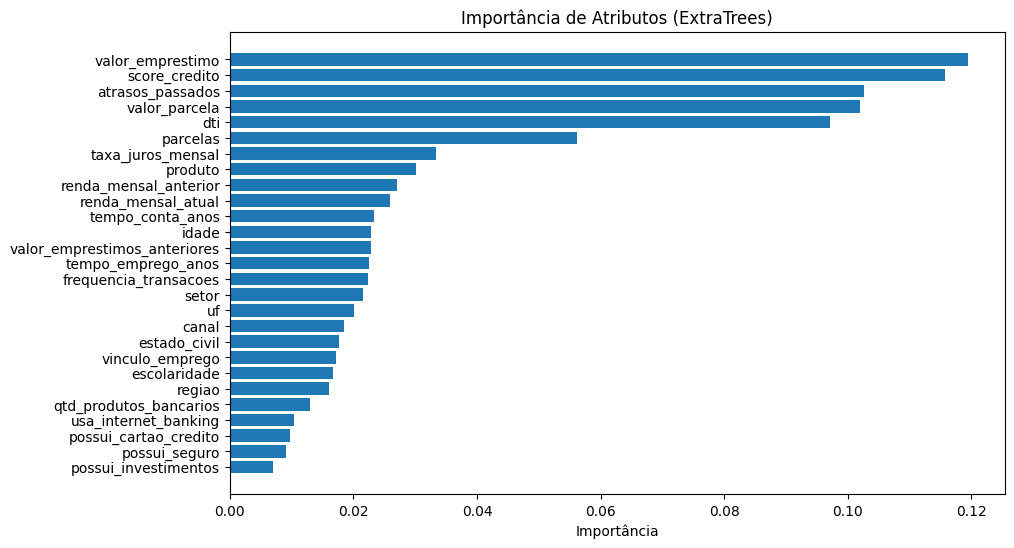

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier

target_col = "inadimplente"

# --- Seleção de features (numéricas, exceto alvo) ---
X = df_baseline_sem_nan.drop(columns=[target_col])
X = X.select_dtypes(include=[np.number])  # apenas colunas numéricas
y = df_baseline_sem_nan[target_col]

# --- Modelo ExtraTrees ---
modelo = ExtraTreesClassifier(n_estimators=200, random_state=42)
modelo.fit(X, y)

# --- Importâncias ---
importancias = modelo.feature_importances_

# Cria dataframe ordenado
df_importancias = pd.DataFrame({
    "Variavel": X.columns,
    "Importancia": importancias
}).sort_values(by="Importancia", ascending=False)

print("\nRanking de Importância de Variáveis:")
display(df_importancias)

# --- Plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_importancias["Variavel"], df_importancias["Importancia"])
plt.gca().invert_yaxis()  # maior no topo
plt.title("Importância de Atributos (ExtraTrees)")
plt.xlabel("Importância")
plt.show()


In [ ]:
# --- Nome da variável resposta ---
target_col = "inadimplente"

# Pega os nomes das 20 variáveis mais importantes
top20_vars = df_importancias["Variavel"].tolist()

# 1) DataFrame só com as 20 variáveis
df_top20 = df_baseline_sem_nan[top20_vars].copy()

# 2) DataFrame com as 20 variáveis + variável resposta
cols_final = top20_vars + [target_col]
df_top20_com_target = df_baseline_sem_nan[cols_final].copy()

print("DataFrame apenas com as 20 variáveis mais importantes:")
display(df_top20)

print("\nDataFrame com as 20 variáveis mais importantes + variável resposta:")
display(df_top20_com_target)


DataFrame apenas com as 20 variáveis mais importantes:


,valor_emprestimo,score_credito,atrasos_passados,valor_parcela,dti,parcelas,taxa_juros_mensal,produto,renda_mensal_anterior,renda_mensal_atual,...,canal,estado_civil,vinculo_emprego,escolaridade,regiao,qtd_produtos_bancarios,usa_internet_banking,possui_cartao_credito,possui_seguro,possui_investimentos
1,44847.64,449,6,2371.85,0.114,36,0.0400,4,16093.58,20757.45,...,1,1,1,0,2,3,1,1,0,1
5,42626.56,585,3,2795.74,0.225,24,0.0400,3,11125.86,12433.62,...,0,2,1,3,2,2,0,0,0,1
6,17433.05,620,5,1095.89,0.196,24,0.0359,4,5741.61,5577.94,...,0,3,0,1,3,1,1,0,0,0
8,17448.36,690,3,3181.54,0.072,6,0.0263,3,39534.11,44370.16,...,2,1,1,3,2,1,0,0,0,0
10,36911.00,485,4,2374.01,0.195,24,0.0381,4,10139.85,12170.38,...,2,0,1,1,0,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,24160.89,690,4,1032.03,0.291,36,0.0254,3,3022.57,3541.94,...,0,2,2,1,3,2,1,1,0,0
999981,26517.19,483,6,993.31,0.050,60,0.0317,2,15575.31,19836.34,...,3,0,3,1,2,3,1,1,0,1
999987,6814.34,485,3,726.08,0.012,12,0.0400,3,58085.81,59766.32,...,0,1,4,1,3,3,1,1,0,1
999992,28213.84,871,0,501.85,0.048,120,0.0147,2,9555.41,10351.21,...,2,2,1,3,3,3,1,1,1,0



DataFrame com as 20 variáveis mais importantes + variável resposta:


,valor_emprestimo,score_credito,atrasos_passados,valor_parcela,dti,parcelas,taxa_juros_mensal,produto,renda_mensal_anterior,renda_mensal_atual,...,estado_civil,vinculo_emprego,escolaridade,regiao,qtd_produtos_bancarios,usa_internet_banking,possui_cartao_credito,possui_seguro,possui_investimentos,inadimplente
1,44847.64,449,6,2371.85,0.114,36,0.0400,4,16093.58,20757.45,...,1,1,0,2,3,1,1,0,1,1
5,42626.56,585,3,2795.74,0.225,24,0.0400,3,11125.86,12433.62,...,2,1,3,2,2,0,0,0,1,0
6,17433.05,620,5,1095.89,0.196,24,0.0359,4,5741.61,5577.94,...,3,0,1,3,1,1,0,0,0,0
8,17448.36,690,3,3181.54,0.072,6,0.0263,3,39534.11,44370.16,...,1,1,3,2,1,0,0,0,0,0
10,36911.00,485,4,2374.01,0.195,24,0.0381,4,10139.85,12170.38,...,0,1,1,0,4,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,24160.89,690,4,1032.03,0.291,36,0.0254,3,3022.57,3541.94,...,2,2,1,3,2,1,1,0,0,0
999981,26517.19,483,6,993.31,0.050,60,0.0317,2,15575.31,19836.34,...,0,3,1,2,3,1,1,0,1,0
999987,6814.34,485,3,726.08,0.012,12,0.0400,3,58085.81,59766.32,...,1,4,1,3,3,1,1,0,1,0
999992,28213.84,871,0,501.85,0.048,120,0.0147,2,9555.41,10351.21,...,2,1,3,3,3,1,1,1,0,0


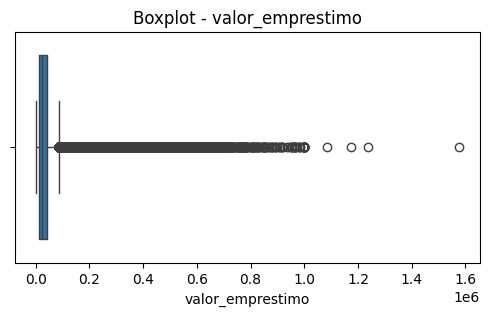

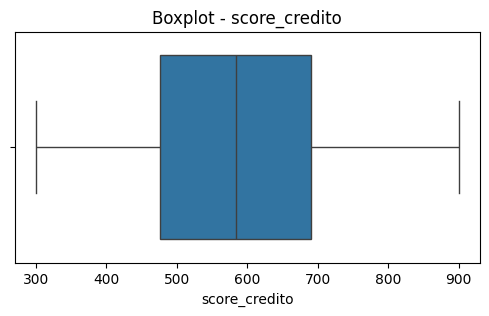

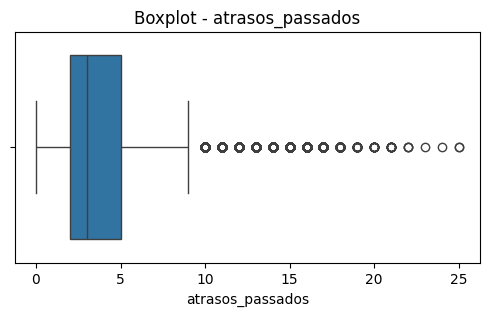

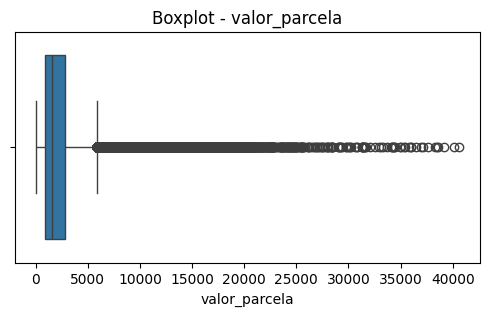

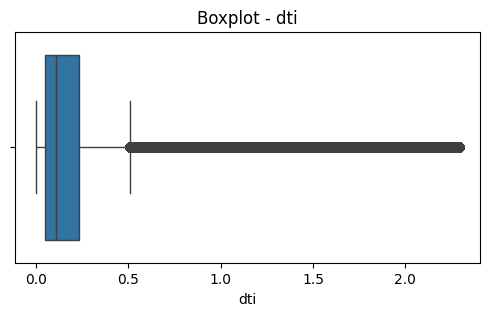

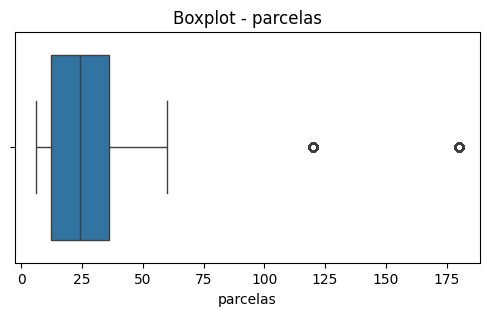

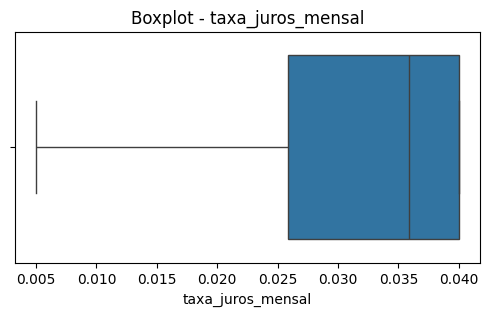

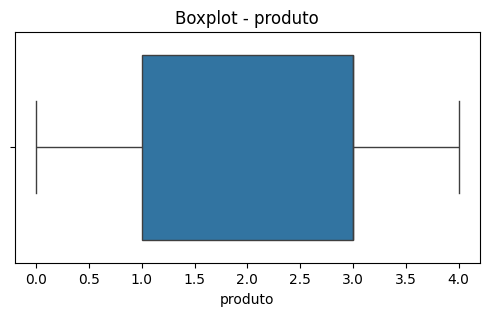

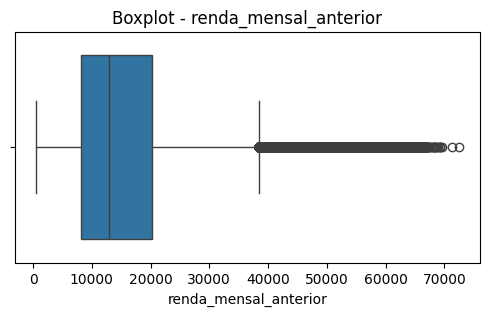

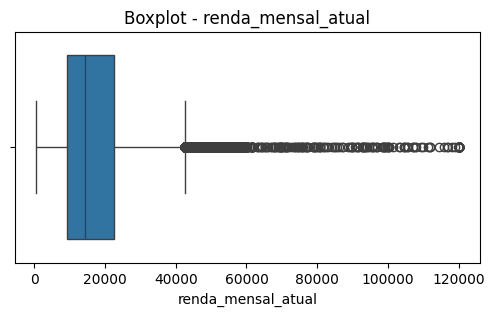

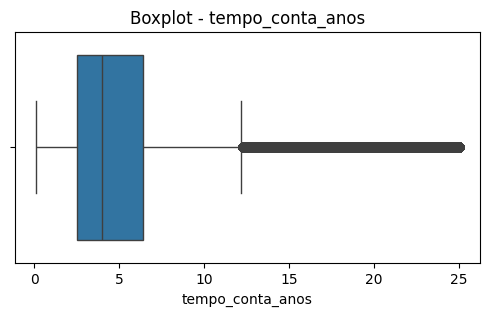

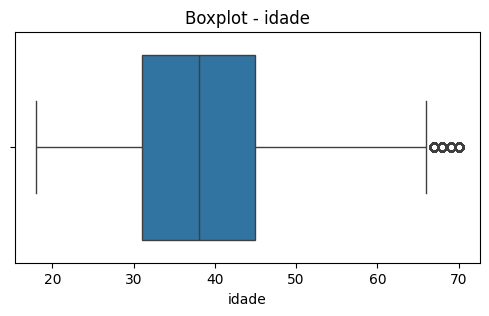

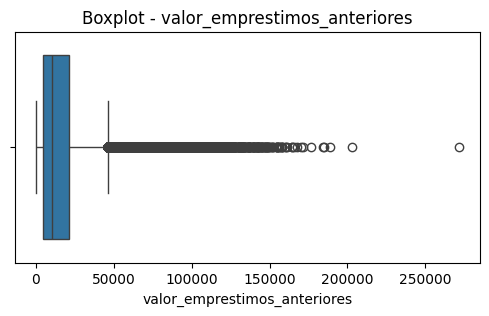

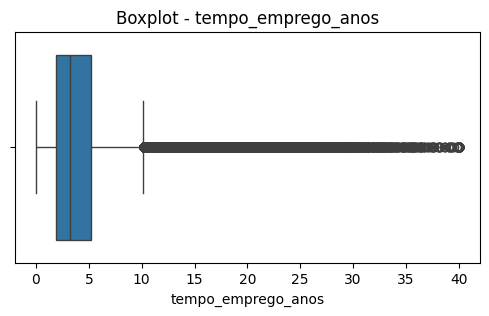

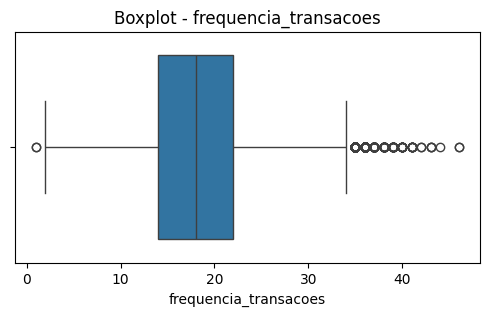

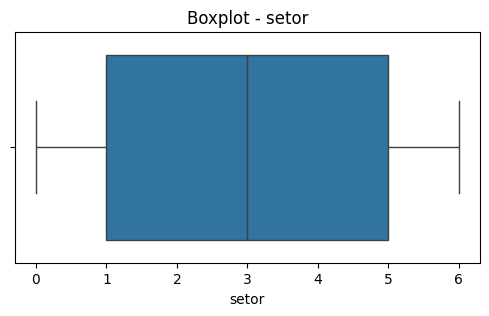

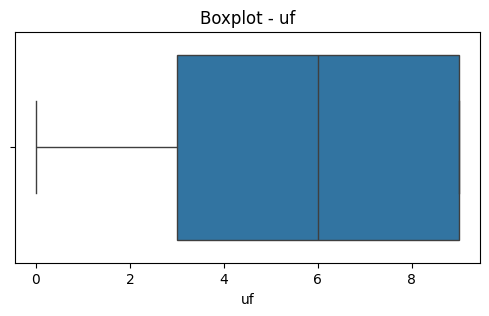

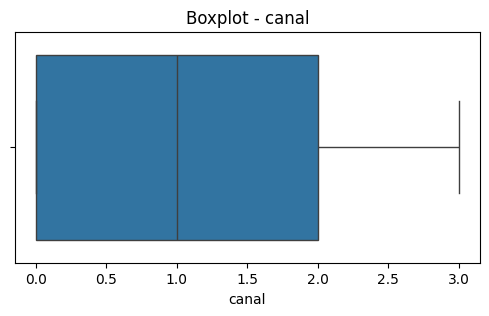

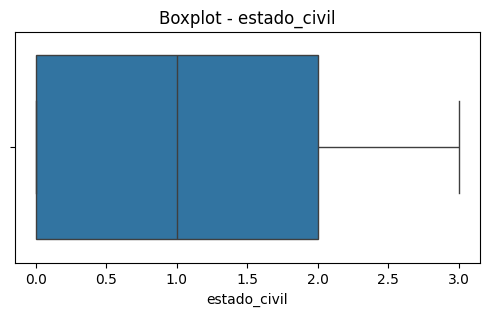

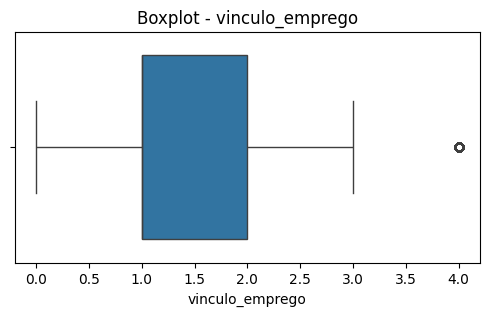

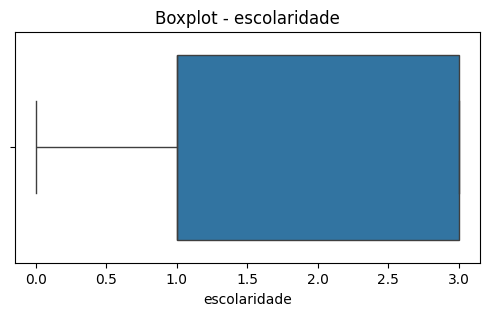

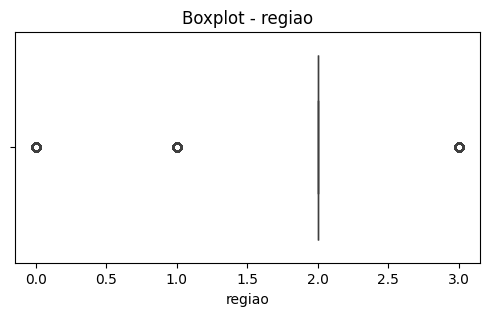

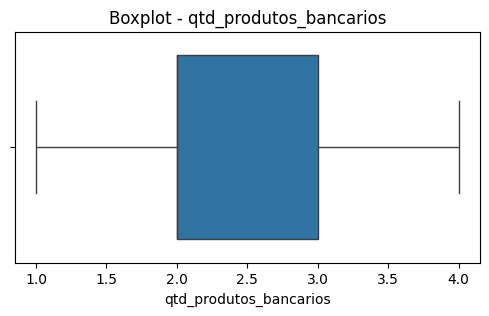

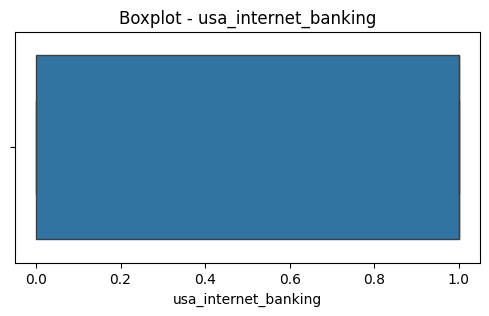

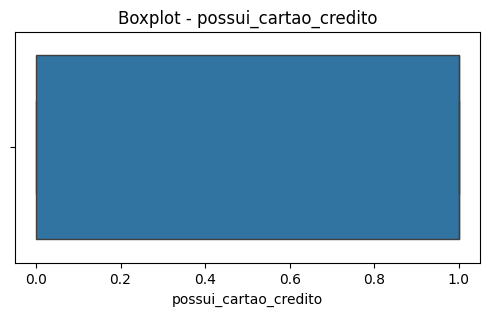

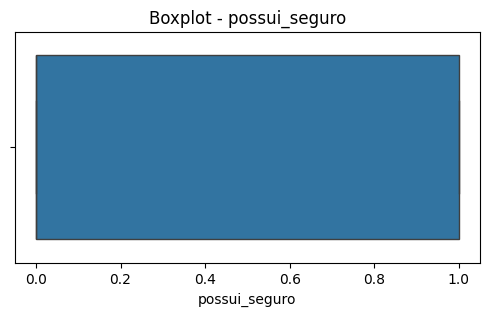

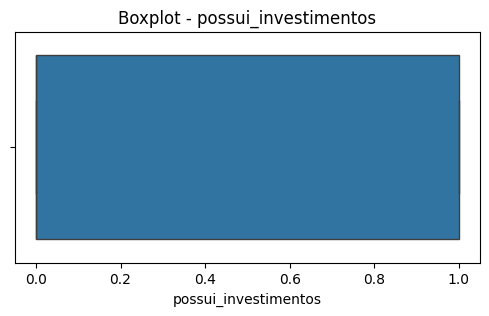

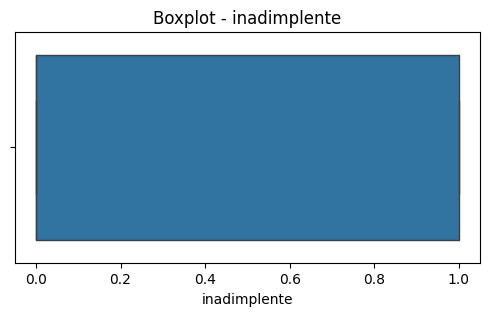

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot para cada variável numérica
for col in df_top20_com_target.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df_top20_com_target[col])
    plt.title(f"Boxplot - {col}")
    plt.show()


In [ ]:
import pandas as pd

def detectar_outliers_iqr(df, fator=1.5):
    """
    Detecta outliers em todas as colunas numéricas usando método IQR.

    Retorna:
      - lista_colunas: lista com nomes das colunas que possuem outliers
      - df_resumo: DataFrame com colunas [coluna, qtd_outliers, perc_outliers]
    """
    resultados = []
    colunas_com_outliers = []
    n_total = len(df)

    for col in df.select_dtypes(include="number").columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        limite_inferior = q1 - fator * iqr
        limite_superior = q3 + fator * iqr

        mask_outliers = (df[col] < limite_inferior) | (df[col] > limite_superior)
        qtd = mask_outliers.sum()

        if qtd > 0:
            colunas_com_outliers.append(col)
            resultados.append({
                "coluna": col,
                "qtd_outliers": qtd,
                "perc_outliers": round(qtd / n_total * 100, 2)
            })

    df_resumo = pd.DataFrame(resultados).sort_values(by="perc_outliers", ascending=False)
    return colunas_com_outliers, df_resumo


In [ ]:
cols_out, df_outliers = detectar_outliers_iqr(df_top20_com_target)

print("Colunas com outliers:", cols_out)
display(df_outliers)

df_colunas_com_outliers_maior_5pct = df_outliers[df_outliers["perc_outliers"] >= 3]
colunas_com_outliers_maior_5pct = list(df_colunas_com_outliers_maior_5pct["coluna"])
colunas_com_outliers_maior_5pct


Colunas com outliers: ['valor_emprestimo', 'atrasos_passados', 'valor_parcela', 'dti', 'parcelas', 'renda_mensal_anterior', 'renda_mensal_atual', 'tempo_conta_anos', 'idade', 'valor_emprestimos_anteriores', 'tempo_emprego_anos', 'frequencia_transacoes', 'vinculo_emprego', 'regiao']


,coluna,qtd_outliers,perc_outliers
13,regiao,134825,39.93
12,vinculo_emprego,33637,9.96
3,dti,28501,8.44
2,valor_parcela,23536,6.97
0,valor_emprestimo,19776,5.86
7,tempo_conta_anos,18631,5.52
10,tempo_emprego_anos,17591,5.21
5,renda_mensal_anterior,17410,5.16
6,renda_mensal_atual,17404,5.15
9,valor_emprestimos_anteriores,17205,5.09


['regiao',
 'vinculo_emprego',
 'dti',
 'valor_parcela',
 'valor_emprestimo',
 'tempo_conta_anos',
 'tempo_emprego_anos',
 'renda_mensal_anterior',
 'renda_mensal_atual',
 'valor_emprestimos_anteriores',
 'atrasos_passados',
 'parcelas']

#### Cluster de Variáveis

##### Opt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from optbinning import OptimalBinning

def _auto_monotonic_trend(x, y):
    """Define monotonicidade automaticamente via correlação de Spearman (sinal)."""
    xr = pd.Series(x).rank(method="average")
    rho = pd.Series(xr).corr(pd.Series(y), method="spearman")
    if pd.isna(rho) or rho == 0:
        return None
    return "ascending" if rho > 0 else "descending"

def binarizar_com_optbinning_multi(
    df: pd.DataFrame,
    colunas: list,
    target: str = "inadimplente",
    max_n_bins: int = 10,
    min_bin_size: float = 0.05,          # fração mínima por bin (ex.: 0.05 = 5%)
    monotonic_trend: str | None | str = "auto",   # "auto", "ascending", "descending" ou None
    special_codes=None,                  # ex.: [np.nan]
    user_splits: dict | None = None,     # {coluna: [splits...]} opcional por coluna
    solver: str = "cp",
    metric_bins: str = "bins",           # "bins" (rótulo textual) ou "indices"
    plot: bool = True,                   # plota gráfico por coluna
    ignore_non_numeric: bool = True      # pula colunas não numéricas se True
):
    """
    Aplica binning ótimo 1D (OptBinning) para cada coluna em `colunas` com base em `target` binário (0/1).

    Retorna:
      - df_out:        df original + colunas 'bin_<col>'
      - bt_dict:       {coluna: binning_table_df}
      - meta_dict:     {coluna: {"monotonic_trend_used", "splits", "iv_total"}}
      - encoders_dict: {coluna: objeto OptimalBinning treinado} (para reuso em produção)
    """
    assert target in df.columns, f"Coluna target '{target}' não encontrada."

    df_out = df.copy()
    bt_dict = {}
    meta_dict = {}
    encoders_dict = {}

    # Garante que user_splits seja dict (pode ser None)
    if user_splits is None:
        user_splits = {}

    for coluna in colunas:
        if coluna not in df.columns:
            print(f"[Aviso] Coluna '{coluna}' não encontrada. Pulando.")
            continue

        # Se solicitado, ignora colunas não numéricas
        if ignore_non_numeric and (not pd.api.types.is_numeric_dtype(df[coluna])):
            print(f"[Aviso] '{coluna}' não é numérica. Pulando (ignore_non_numeric=True).")
            continue

        # Filtra amostra válida
        mask_valid = df[coluna].notna() & df[target].isin([0, 1])
        x = df.loc[mask_valid, coluna].astype(float).values
        y = df.loc[mask_valid, target].astype(int).values

        if x.size == 0:
            print(f"[Aviso] '{coluna}' não possui dados válidos com target em {{0,1}}. Pulando.")
            continue

        # Define monotonicidade
        mono = monotonic_trend
        if monotonic_trend == "auto":
            mono = _auto_monotonic_trend(x, y)

        # Instancia e treina
        optb = OptimalBinning(
            name=coluna,
            dtype="numerical",
            solver=solver,
            monotonic_trend=mono,
            max_n_bins=max_n_bins,
            min_bin_size=min_bin_size,
            special_codes=special_codes,
            user_splits=user_splits.get(coluna)  # permite splits específicos por coluna
        )
        optb.fit(x, y)

        # Tabela de bins
        bt = optb.binning_table
        bt_df = bt.build()

        # IV total (compatível com versões diferentes)
        try:
            iv_total = float(bt_df["IV"].sum())
        except Exception:
            iv_total = getattr(bt, "iv", np.nan)

        # Transform (labels textuais ou índices)
        bins_vals = optb.transform(x, metric=metric_bins)  # "bins" -> "(-inf, 1200]" | "indices" -> 0,1,2,...

        # Escreve no df_out
        bin_col = f"bin_{coluna}"
        df_out[bin_col] = pd.NA
        df_out.loc[mask_valid, bin_col] = bins_vals.astype(object)  # garante dtype capaz de texto/índice

        # Guarda saídas
        bt_dict[coluna] = bt_df
        meta_dict[coluna] = {
            "monotonic_trend_used": mono,
            "splits": getattr(optb, "splits", None),
            "iv_total": iv_total
        }
        encoders_dict[coluna] = optb

        # Plot simples por coluna
        if plot:
            aux = bt_df.copy()
            aux["Bin"] = aux["Bin"].astype(str)
            fig, ax1 = plt.subplots(figsize=(10, 4))
            sns.barplot(x="Bin", y="Event rate", data=aux, ax=ax1)
            ax1.set_ylabel("Event rate")
            ax1.set_xlabel("Bins")
            ax1.set_title(f"[{coluna}] Binning por '{target}' (monotonic: {mono})")
            ax1.tick_params(axis="x", rotation=45)

            ax2 = ax1.twinx()
            ax2.plot(aux["Bin"], aux["Count"], marker="o")
            ax2.set_ylabel("Count")
            plt.tight_layout()
            plt.show()

    # Informativos finais
    if not bt_dict:
        print("[Aviso] Nenhuma coluna foi processada. Verifique a lista ou tipos/target.")

    return df_out, bt_dict, meta_dict, encoders_dict


In [ ]:
colunas_para_binning = colunas_com_outliers_maior_5pct

df_bins, tabelas, metas, modelos = binarizar_com_optbinning_multi(
    df=df_top20_com_target,
    colunas=colunas_para_binning,
    target="inadimplente",
    max_n_bins=10,
    min_bin_size=0.05,
    monotonic_trend="auto",          # usa Spearman para decidir
    special_codes=[np.nan],          # deixa o optbinning lidar com NaN
    user_splits={"renda": [2000, 10000, 50000]},  # opcional (por coluna)
    solver="cp",
    metric_bins="bins",              # "bins" (texto) ou "indices"
    plot=False,
    ignore_non_numeric=True
)

# df_bins agora tem colunas: bin_renda, bin_saldo_devedor, bin_percentual_utilizacao
# tabelas["renda"] -> DataFrame com WOE/IV/Event rate etc.
# metas["renda"]["iv_total"] -> IV total da variável
# modelos["renda"] -> objeto OptimalBinning treinado (para reuso em produção)
display(df_bins)
display(tabelas)


c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\d

,valor_emprestimo,score_credito,atrasos_passados,valor_parcela,dti,parcelas,taxa_juros_mensal,produto,renda_mensal_anterior,renda_mensal_atual,...,bin_dti,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_tempo_emprego_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas
1,44847.64,449,6,2371.85,0.114,36,0.0400,4,16093.58,20757.45,...,"[0.08, 0.12)","[2362.12, 2797.86)","[34653.91, 46703.44)","[2.35, 3.45)","[3.25, 9.85)","[15285.65, 17679.05)","[17645.88, 21410.46)","[14689.00, 23597.21)","[5.50, 7.50)","[30.00, 42.00)"
5,42626.56,585,3,2795.74,0.225,24,0.0400,3,11125.86,12433.62,...,"[0.19, 0.29)","[2362.12, 2797.86)","[34653.91, 46703.44)","[5.05, 6.35)","[9.85, inf)","[9985.92, 12626.35)","[11933.63, 13648.93)","[23597.21, inf)","[2.50, 3.50)","[21.00, 30.00)"
6,17433.05,620,5,1095.89,0.196,24,0.0359,4,5741.61,5577.94,...,"[0.19, 0.29)","[1040.65, 1550.95)","[15909.70, 19795.43)","[6.35, 7.55)","[0.15, 3.25)","[5128.86, 7171.15)","(-inf, 5636.69)","[14689.00, 23597.21)","[4.50, 5.50)","[21.00, 30.00)"
8,17448.36,690,3,3181.54,0.072,6,0.0263,3,39534.11,44370.16,...,"[0.06, 0.08)","[2797.86, 3815.92)","[15909.70, 19795.43)","[3.45, 4.05)","[0.15, 3.25)","[34182.38, inf)","[37125.03, inf)","(-inf, 5674.04)","[2.50, 3.50)","(-inf, 21.00)"
10,36911.00,485,4,2374.01,0.195,24,0.0381,4,10139.85,12170.38,...,"[0.19, 0.29)","[2362.12, 2797.86)","[34653.91, 46703.44)","[7.55, 9.05)","[0.15, 3.25)","[9985.92, 12626.35)","[11933.63, 13648.93)","[5674.04, 12412.45)","[3.50, 4.50)","[21.00, 30.00)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,24160.89,690,4,1032.03,0.291,36,0.0254,3,3022.57,3541.94,...,"[0.29, 0.42)","[811.88, 1040.65)","[19795.43, 25755.53)","[9.05, 11.45)","(-inf, 0.15)","(-inf, 5128.86)","(-inf, 5636.69)","[5674.04, 12412.45)","[3.50, 4.50)","[30.00, 42.00)"
999981,26517.19,483,6,993.31,0.050,60,0.0317,2,15575.31,19836.34,...,"[0.04, 0.06)","[811.88, 1040.65)","[25755.53, 34653.91)","[2.35, 3.45)","[0.15, 3.25)","[15285.65, 17679.05)","[17645.88, 21410.46)","(-inf, 5674.04)","[5.50, 7.50)","[54.00, inf)"
999987,6814.34,485,3,726.08,0.012,12,0.0400,3,58085.81,59766.32,...,"(-inf, 0.03)","[517.28, 811.88)","(-inf, 10752.14)","[2.35, 3.45)","[3.25, 9.85)","[34182.38, inf)","[37125.03, inf)","[23597.21, inf)","[2.50, 3.50)","(-inf, 21.00)"
999992,28213.84,871,0,501.85,0.048,120,0.0147,2,9555.41,10351.21,...,"[0.04, 0.06)","(-inf, 517.28)","[25755.53, 34653.91)","[2.35, 3.45)","[0.15, 3.25)","[7171.15, 9985.92)","[9021.66, 11933.63)","[23597.21, inf)","(-inf, 0.50)","[54.00, inf)"


{'regiao':                  Bin   Count  Count (%)  Non-event   Event  Event rate  \
 0       (-inf, 1.50)   67215   0.199043      44962   22253    0.331072   
 1       [1.50, 2.50)  202866   0.600744     137332   65534    0.323041   
 2        [2.50, inf)   67610   0.200213      45840   21770    0.321994   
 3            Special       0   0.000000          0       0    0.000000   
 4            Missing       0   0.000000          0       0    0.000000   
 Totals                337691   1.000000     228134  109557    0.324430   
 
              WoE        IV        JS  
 0      -0.030147  0.000182  0.000023  
 1       0.006344  0.000024  0.000003  
 2       0.011136  0.000025  0.000003  
 3            0.0  0.000000  0.000000  
 4            0.0  0.000000  0.000000  
 Totals            0.000231  0.000029  ,
 'vinculo_emprego':                  Bin   Count  Count (%)  Non-event   Event  Event rate  \
 0       (-inf, 0.50)   67238   0.199111      44357   22881    0.340299   
 1       [0.5

In [ ]:
import re
import numpy as np
import pandas as pd

_INTERVAL_RE = re.compile(
    r"^\s*([\[\(])\s*([-\w\.]+)\s*,\s*([-\w\.]+)\s*([\]\)])\s*$",
    flags=re.IGNORECASE
)

def _parse_endpoint(x: str) -> float:
    x = str(x).strip().lower()
    if x in ("-inf", "-infinity", "-∞"):
        return -np.inf
    if x in ("inf", "+inf", "infinity", "∞"):
        return np.inf
    return float(x)

def _bt_from_bin_strings(bt: pd.DataFrame) -> pd.DataFrame:
    """
    Converte uma binning table no formato com coluna 'Bin' textual para
    um DataFrame com colunas ['Bin', 'Lower bound', 'Upper bound'] apenas
    nas linhas de intervalo (descarta Totals/Special/Missing aqui).
    Retorna (somente intervalos).
    """
    rows = []
    for _, r in bt.iterrows():
        b = str(r.get("Bin", ""))
        if b.lower() in ("totals",):
            continue
        if b.lower() in ("special", "missing"):
            # Não vira intervalo; tratado fora.
            continue
        m = _INTERVAL_RE.match(b)
        if not m:
            # Linha que não é intervalo reconhecível → ignora
            continue
        left_br, lb_txt, ub_txt, right_br = m.groups()
        lb = _parse_endpoint(lb_txt)
        ub = _parse_endpoint(ub_txt)
        # Guardamos o rótulo original (Bin) como label textual
        rows.append({"Bin": b, "Lower bound": lb, "Upper bound": ub})
    if not rows:
        return pd.DataFrame(columns=["Bin", "Lower bound", "Upper bound"])
    out = pd.DataFrame(rows)

    # Ordena por limites e garante contiguidade (assumida)
    order = np.lexsort((out["Upper bound"].to_numpy(), out["Lower bound"].to_numpy()))
    out = out.iloc[order].reset_index(drop=True)
    return out

def aplicar_bins_por_tabelas(
    df: pd.DataFrame,
    bt_dict: dict,
    colunas: list | None = None,
    prefixo: str = "bin_",
    saida: str = "labels",            # "labels" ou "indices"
    ignore_non_numeric: bool = True,
    special_codes_map: dict | None = None  # ex.: {"renda": [0, -1, np.nan], "saldo": [999999999]}
):
    """
    Aplica bins conforme tabelas em bt_dict.
    Aceita:
      1) Tabelas com ["Lower bound","Upper bound","Bin"] (padrão)
      2) Tabelas com ["Bin"] textual nos moldes '(-inf, 1.50)', '[1.50, 2.50)', etc.,
         com linhas 'Special' e 'Missing'.
    Assume intervalos CONTÍGUOS e aplica a convenção (lb, ub] (right=True).
    """
    df_out = df.copy()
    info = {}

    if colunas is None:
        colunas = [c for c in bt_dict.keys() if c in df_out.columns]

    for col in colunas:
        if col not in df_out.columns:
            print(f"[Aviso] '{col}' não está no DataFrame. Pulando.")
            continue
        if ignore_non_numeric and (not pd.api.types.is_numeric_dtype(df_out[col])):
            print(f"[Aviso] '{col}' não é numérica. Pulando (ignore_non_numeric=True).")
            continue

        raw_bt = bt_dict.get(col)
        if raw_bt is None or "Bin" not in raw_bt.columns:
            print(f"[Aviso] Tabela de bins inválida para '{col}'. Pulando.")
            continue

        # Detecta rótulos de Special/Missing (se existirem)
        label_special = None
        label_missing = None
        if "Bin" in raw_bt.columns:
            if (raw_bt["Bin"].astype(str).str.lower() == "special").any():
                label_special = "Special"
            if (raw_bt["Bin"].astype(str).str.lower() == "missing").any():
                label_missing = "Missing"

        # Normaliza para formato com limites
        if {"Lower bound", "Upper bound"}.issubset(raw_bt.columns):
            btf = raw_bt.loc[:, ["Bin", "Lower bound", "Upper bound"]].copy()
            # remove linhas sem limites (ex.: Special/Missing/Totals)
            btf = btf[btf["Lower bound"].notna() | btf["Upper bound"].notna()].copy()
        else:
            btf = _bt_from_bin_strings(raw_bt)

        if btf.empty:
            print(f"[Aviso] Nenhum intervalo encontrado para '{col}'. Pulando.")
            continue

        lbs = btf["Lower bound"].to_numpy()
        ubs = btf["Upper bound"].to_numpy()

        lbs = np.where(pd.isna(lbs), -np.inf, lbs.astype(float))
        ubs = np.where(pd.isna(ubs),  np.inf,  ubs.astype(float))

        # Ordena
        order = np.lexsort((ubs, lbs))
        lbs = lbs[order]
        ubs = ubs[order]
        labels = btf["Bin"].astype(str).to_numpy()[order]

        # edges para pd.cut com right=True => (lb, ub]
        edges = [lbs[0]] + list(ubs)

        s = df_out[col].astype(float)
        binned = pd.cut(s, bins=edges, labels=labels, right=True, include_lowest=False)

        # Missing: valores NaN no dado → rotula como 'Missing' se existir
        if label_missing is not None:
            is_nan = s.isna()
            if is_nan.any():
                binned = binned.astype(object)
                binned[is_nan] = label_missing

        # Special: valores explícitos fornecidos no special_codes_map → rotula 'Special'
        if special_codes_map and col in special_codes_map and label_special is not None:
            vals_special = special_codes_map[col]
            is_special = s.isin(vals_special)
            if is_special.any():
                binned = binned.astype(object)
                binned[is_special] = label_special

        out_col = f"{prefixo}{col}"
        if saida == "labels":
            df_out[out_col] = binned.astype("object")
        elif saida == "indices":
            cat = pd.Categorical(binned, categories=list(labels), ordered=True)
            # Observação: 'Missing'/'Special' (se usados) não estão em 'labels' -> viram -1
            df_out[out_col] = cat.codes.astype("int32")
        else:
            raise ValueError("Parâmetro 'saida' deve ser 'labels' ou 'indices'.")

        info[col] = {"labels": list(labels), "edges": edges}

    return df_out, info


In [ ]:
# Supondo que você já tenha bt_dict vindo do seu binarizar_com_optbinning_multi(...)
# e quer aplicar as mesmas faixas em um novo df (ex.: df_validacao):

df_val_binado, info_bins = aplicar_bins_por_tabelas(
    df=df_monitoramento_encoded,
    bt_dict=tabelas,
    colunas=list(tabelas.keys()),  # ou uma sublista
    prefixo="bin_",
    saida="labels",                 # ou "indices"
    ignore_non_numeric=True,
    special_codes_map=None          # ou {"renda": [0, -1, np.nan]}
)

display(df_val_binado)
display(df_val_binado.columns)

df_monitoramento_encoded_binado = df_val_binado
display(df_monitoramento_encoded_binado)
display(df_monitoramento_encoded_binado["bin_tempo_emprego_anos"].value_counts())


# Agora df_val_binado contém colunas como bin_renda, bin_saldo_devedor, ...


,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,bin_dti,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_tempo_emprego_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas
4,4,1,35,3.0,3,4,2,0,0,4,...,"[0.08, 0.12)","[2797.86, 3815.92)","[56383.24, 69977.16)","[2.35, 3.45)","[3.25, 9.85)","[34182.38, inf)","[37125.03, inf)","[5674.04, 12412.45)","[7.50, inf)","[30.00, 42.00)"
12,9,2,38,2.3,0,1,0,2,4,1,...,"[0.12, 0.19)","[1550.95, 1884.55)","[15909.70, 19795.43)","[1.35, 2.35)","[9.85, inf)","[7171.15, 9985.92)","[9021.66, 11933.63)","[23597.21, inf)","[0.50, 1.50)","(-inf, 21.00)"
18,8,3,29,4.8,0,1,3,2,2,3,...,"[0.04, 0.06)","(-inf, 517.28)","(-inf, 10752.14)","[4.05, 5.05)","(-inf, 0.15)","(-inf, 5128.86)","(-inf, 5636.69)","[23597.21, inf)","[5.50, 7.50)","[42.00, 54.00)"
28,2,0,49,24.4,1,3,0,0,0,2,...,"[0.12, 0.19)","[517.28, 811.88)","(-inf, 10752.14)","[11.45, inf)","[3.25, 9.85)","[5128.86, 7171.15)","[5636.69, 7381.37)","[23597.21, inf)","[7.50, inf)","(-inf, 21.00)"
31,3,2,36,25.0,1,3,2,2,0,6,...,"[0.66, inf)","[2797.86, 3815.92)","[46703.44, 56383.24)","[11.45, inf)","[0.15, 3.25)","(-inf, 5128.86)","(-inf, 5636.69)","(-inf, 5674.04)","[1.50, 2.50)","(-inf, 21.00)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999986,4,1,41,6.9,1,4,2,1,0,4,...,"[0.06, 0.08)","[1040.65, 1550.95)","[25755.53, 34653.91)","[6.35, 7.55)","[0.15, 3.25)","[17679.05, 21293.55)","[21410.46, 27792.28)","(-inf, 5674.04)","(-inf, 0.50)","[21.00, 30.00)"
999993,6,2,38,8.3,0,4,2,0,1,6,...,"[0.06, 0.08)","[1550.95, 1884.55)","[34653.91, 46703.44)","[7.55, 9.05)","[3.25, 9.85)","[17679.05, 21293.55)","[17645.88, 21410.46)","[14689.00, 23597.21)","[2.50, 3.50)","[54.00, inf)"
999996,6,2,55,7.0,3,1,0,0,1,0,...,"[0.29, 0.42)","[1550.95, 1884.55)","[15909.70, 19795.43)","[6.35, 7.55)","[3.25, 9.85)","(-inf, 5128.86)","(-inf, 5636.69)","(-inf, 5674.04)","[1.50, 2.50)","(-inf, 21.00)"
999997,0,1,24,1.5,3,1,2,0,1,3,...,"[0.06, 0.08)","[1884.55, 2362.12)","[69977.16, 95803.96)","[1.35, 2.35)","[3.25, 9.85)","[28089.74, 34182.38)","[27792.28, 37125.03)","(-inf, 5674.04)","[0.50, 1.50)","[54.00, inf)"


Index(['uf', 'regiao', 'idade', 'tempo_conta_anos', 'canal', 'produto',
       'escolaridade', 'estado_civil', 'vinculo_emprego', 'setor',
       'usa_internet_banking', 'possui_cartao_credito', 'possui_investimentos',
       'possui_seguro', 'qtd_produtos_bancarios', 'renda_mensal_atual',
       'renda_mensal_anterior', 'atrasos_passados', 'score_credito',
       'parcelas', 'valor_emprestimo', 'taxa_juros_mensal', 'valor_parcela',
       'dti', 'frequencia_transacoes', 'valor_emprestimos_anteriores',
       'inadimplente', 'tempo_emprego_anos', 'bin_regiao',
       'bin_vinculo_emprego', 'bin_dti', 'bin_valor_parcela',
       'bin_valor_emprestimo', 'bin_tempo_conta_anos',
       'bin_tempo_emprego_anos', 'bin_renda_mensal_anterior',
       'bin_renda_mensal_atual', 'bin_valor_emprestimos_anteriores',
       'bin_atrasos_passados', 'bin_parcelas'],
      dtype='object')

,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,bin_dti,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_tempo_emprego_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas
4,4,1,35,3.0,3,4,2,0,0,4,...,"[0.08, 0.12)","[2797.86, 3815.92)","[56383.24, 69977.16)","[2.35, 3.45)","[3.25, 9.85)","[34182.38, inf)","[37125.03, inf)","[5674.04, 12412.45)","[7.50, inf)","[30.00, 42.00)"
12,9,2,38,2.3,0,1,0,2,4,1,...,"[0.12, 0.19)","[1550.95, 1884.55)","[15909.70, 19795.43)","[1.35, 2.35)","[9.85, inf)","[7171.15, 9985.92)","[9021.66, 11933.63)","[23597.21, inf)","[0.50, 1.50)","(-inf, 21.00)"
18,8,3,29,4.8,0,1,3,2,2,3,...,"[0.04, 0.06)","(-inf, 517.28)","(-inf, 10752.14)","[4.05, 5.05)","(-inf, 0.15)","(-inf, 5128.86)","(-inf, 5636.69)","[23597.21, inf)","[5.50, 7.50)","[42.00, 54.00)"
28,2,0,49,24.4,1,3,0,0,0,2,...,"[0.12, 0.19)","[517.28, 811.88)","(-inf, 10752.14)","[11.45, inf)","[3.25, 9.85)","[5128.86, 7171.15)","[5636.69, 7381.37)","[23597.21, inf)","[7.50, inf)","(-inf, 21.00)"
31,3,2,36,25.0,1,3,2,2,0,6,...,"[0.66, inf)","[2797.86, 3815.92)","[46703.44, 56383.24)","[11.45, inf)","[0.15, 3.25)","(-inf, 5128.86)","(-inf, 5636.69)","(-inf, 5674.04)","[1.50, 2.50)","(-inf, 21.00)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999986,4,1,41,6.9,1,4,2,1,0,4,...,"[0.06, 0.08)","[1040.65, 1550.95)","[25755.53, 34653.91)","[6.35, 7.55)","[0.15, 3.25)","[17679.05, 21293.55)","[21410.46, 27792.28)","(-inf, 5674.04)","(-inf, 0.50)","[21.00, 30.00)"
999993,6,2,38,8.3,0,4,2,0,1,6,...,"[0.06, 0.08)","[1550.95, 1884.55)","[34653.91, 46703.44)","[7.55, 9.05)","[3.25, 9.85)","[17679.05, 21293.55)","[17645.88, 21410.46)","[14689.00, 23597.21)","[2.50, 3.50)","[54.00, inf)"
999996,6,2,55,7.0,3,1,0,0,1,0,...,"[0.29, 0.42)","[1550.95, 1884.55)","[15909.70, 19795.43)","[6.35, 7.55)","[3.25, 9.85)","(-inf, 5128.86)","(-inf, 5636.69)","(-inf, 5674.04)","[1.50, 2.50)","(-inf, 21.00)"
999997,0,1,24,1.5,3,1,2,0,1,3,...,"[0.06, 0.08)","[1884.55, 2362.12)","[69977.16, 95803.96)","[1.35, 2.35)","[3.25, 9.85)","[28089.74, 34182.38)","[27792.28, 37125.03)","(-inf, 5674.04)","[0.50, 1.50)","[54.00, inf)"


bin_tempo_emprego_anos
[0.15, 3.25)    99383
[3.25, 9.85)    92439
[9.85, inf)     12131
(-inf, 0.15)    10834
Missing          8063
Name: count, dtype: int64

In [ ]:
display(df_bins.columns)
df_bins.dtypes
display(df_bins["bin_tempo_emprego_anos"].value_counts())

Index(['valor_emprestimo', 'score_credito', 'atrasos_passados',
       'valor_parcela', 'dti', 'parcelas', 'taxa_juros_mensal', 'produto',
       'renda_mensal_anterior', 'renda_mensal_atual', 'tempo_conta_anos',
       'idade', 'valor_emprestimos_anteriores', 'tempo_emprego_anos',
       'frequencia_transacoes', 'setor', 'uf', 'canal', 'estado_civil',
       'vinculo_emprego', 'escolaridade', 'regiao', 'qtd_produtos_bancarios',
       'usa_internet_banking', 'possui_cartao_credito', 'possui_seguro',
       'possui_investimentos', 'inadimplente', 'bin_regiao',
       'bin_vinculo_emprego', 'bin_dti', 'bin_valor_parcela',
       'bin_valor_emprestimo', 'bin_tempo_conta_anos',
       'bin_tempo_emprego_anos', 'bin_renda_mensal_anterior',
       'bin_renda_mensal_atual', 'bin_valor_emprestimos_anteriores',
       'bin_atrasos_passados', 'bin_parcelas'],
      dtype='object')

bin_tempo_emprego_anos
[0.15, 3.25)    156348
[3.25, 9.85)    145019
[9.85, inf)      19196
(-inf, 0.15)     17128
Name: count, dtype: int64

In [ ]:
import pandas as pd

def comparar_distintos(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    colunas: list[str],
    considerar_na_como_valor: bool = True,
    token_na: str = "<NA>"
) -> tuple[pd.DataFrame, bool]:
    """
    Compara, para cada coluna em `colunas`, se o conjunto de valores distintos é igual entre df1 e df2.
    - A contagem/frequência NÃO importa.
    - Por padrão, NaN/None é tratado como um valor especial e comparado.

    Retorna:
      (resultado_df, todas_iguais)
      onde resultado_df tem:
        - coluna
        - iguais (bool)
        - so_no_df1 (lista dos valores que só aparecem no df1)
        - so_no_df2 (lista dos valores que só aparecem no df2)
    """
    def _distinct_set(sr: pd.Series) -> set:
        if considerar_na_como_valor:
            has_na = sr.isna().any()
            vals = set(sr.dropna().unique().tolist())
            if has_na:
                vals.add(token_na)
            return vals
        # sem normalização de NaN: remove NaN da comparação para evitar NaN != NaN
        return set(sr.dropna().unique().tolist())

    resultados = []
    for col in colunas:
        if col not in df1.columns or col not in df2.columns:
            resultados.append({
                "coluna": col,
                "iguais": False,
                "so_no_df1": None if col in df1.columns else "<coluna ausente no df1>",
                "so_no_df2": None if col in df2.columns else "<coluna ausente no df2>",
            })
            continue

        s1 = _distinct_set(df1[col])
        s2 = _distinct_set(df2[col])

        only1 = sorted(s1 - s2, key=lambda x: (str(type(x)), str(x)))
        only2 = sorted(s2 - s1, key=lambda x: (str(type(x)), str(x)))

        resultados.append({
            "coluna": col,
            "iguais": len(only1) == 0 and len(only2) == 0,
            "so_no_df1": only1,
            "so_no_df2": only2,
        })

    out = pd.DataFrame(resultados)
    return out, bool(out["iguais"].all())


In [ ]:
cols = ['bin_regiao',
       'bin_vinculo_emprego', 'bin_dti', 'bin_valor_parcela',
       'bin_valor_emprestimo', 'bin_tempo_conta_anos',
       'bin_tempo_emprego_anos', 'bin_renda_mensal_anterior',
       'bin_renda_mensal_atual', 'bin_valor_emprestimos_anteriores',
       'bin_atrasos_passados', 'bin_parcelas']

tabela, todas_iguais = comparar_distintos(
    df1=df_bins,
    df2=df_monitoramento_encoded_binado,
    colunas=cols
)

print(tabela)        # tabela com diferenças por coluna
print(todas_iguais)  # True se todas as colunas têm os mesmos valores distintos


                              coluna  iguais so_no_df1  so_no_df2
0                         bin_regiao    True        []         []
1                bin_vinculo_emprego    True        []         []
2                            bin_dti    True        []         []
3                  bin_valor_parcela    True        []         []
4               bin_valor_emprestimo    True        []         []
5               bin_tempo_conta_anos    True        []         []
6             bin_tempo_emprego_anos   False        []  [Missing]
7          bin_renda_mensal_anterior   False        []  [Missing]
8             bin_renda_mensal_atual   False        []  [Missing]
9   bin_valor_emprestimos_anteriores   False        []  [Missing]
10              bin_atrasos_passados    True        []         []
11                      bin_parcelas    True        []         []
False


In [ ]:
# Filtra só as linhas com algum NaN
linhas_missing = df_monitoramento_encoded_binado[df_monitoramento_encoded_binado.isna().any(axis=1)]
display(linhas_missing)

,uf,regiao,idade,tempo_conta_anos,canal,produto,escolaridade,estado_civil,vinculo_emprego,setor,...,bin_dti,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_tempo_emprego_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas
38,8,3,41,2.8,1,3,1,0,0,0,...,"[0.06, 0.08)","[517.28, 811.88)","(-inf, 10752.14)","[2.35, 3.45)",Missing,"[7171.15, 9985.92)","[9021.66, 11933.63)","[23597.21, inf)","[1.50, 2.50)","(-inf, 21.00)"
47,8,3,35,6.0,3,0,1,2,1,4,...,"(-inf, 0.03)","(-inf, 517.28)","(-inf, 10752.14)","[5.05, 6.35)",Missing,"[34182.38, inf)","[37125.03, inf)","[5674.04, 12412.45)","[7.50, inf)","[21.00, 30.00)"
126,9,2,32,2.6,0,3,1,0,1,3,...,"[0.04, 0.06)","[1040.65, 1550.95)","[15909.70, 19795.43)","[2.35, 3.45)","[3.25, 9.85)","[17679.05, 21293.55)","[17645.88, 21410.46)",Missing,"[2.50, 3.50)","(-inf, 21.00)"
130,3,2,38,5.7,2,4,1,2,1,6,...,"[0.04, 0.06)","[1040.65, 1550.95)","[34653.91, 46703.44)","[5.05, 6.35)",Missing,"[21293.55, 28089.74)","[21410.46, 27792.28)","[5674.04, 12412.45)","[1.50, 2.50)","[54.00, inf)"
139,9,2,43,3.2,0,3,2,1,1,6,...,"[0.06, 0.08)","[1040.65, 1550.95)","[25755.53, 34653.91)","[2.35, 3.45)","[0.15, 3.25)",Missing,Missing,Missing,"[1.50, 2.50)","[30.00, 42.00)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999831,3,2,30,2.9,1,3,1,0,1,1,...,"[0.19, 0.29)","[2362.12, 2797.86)","[46703.44, 56383.24)","[2.35, 3.45)","[3.25, 9.85)",Missing,"[9021.66, 11933.63)","[5674.04, 12412.45)","[2.50, 3.50)","[30.00, 42.00)"
999850,3,2,48,7.0,3,3,1,0,4,5,...,"[0.06, 0.08)","[1550.95, 1884.55)","(-inf, 10752.14)","[6.35, 7.55)","[9.85, inf)","[21293.55, 28089.74)",Missing,"[5674.04, 12412.45)","[2.50, 3.50)","(-inf, 21.00)"
999898,9,2,42,2.5,1,0,0,1,3,5,...,"[0.08, 0.12)","[1040.65, 1550.95)","(-inf, 10752.14)","[2.35, 3.45)","[3.25, 9.85)",Missing,"[11933.63, 13648.93)","(-inf, 5674.04)","[5.50, 7.50)","(-inf, 21.00)"
999922,2,0,29,22.5,3,0,1,2,1,3,...,"[0.42, 0.66)","[2797.86, 3815.92)","[15909.70, 19795.43)","[11.45, inf)","[9.85, inf)","[5128.86, 7171.15)","(-inf, 5636.69)",Missing,"[2.50, 3.50)","(-inf, 21.00)"


In [ ]:
df_bins["tag_etapa_modelagem"] = "baseline"
df_monitoramento_encoded_binado["tag_etapa_modelagem"] = "monitoramento"

display(df_bins["tag_etapa_modelagem"].value_counts())
display(df_monitoramento_encoded_binado["tag_etapa_modelagem"].value_counts())

tag_etapa_modelagem
baseline    337691
Name: count, dtype: int64

tag_etapa_modelagem
monitoramento    222850
Name: count, dtype: int64

In [ ]:
import pandas as pd

def append_se_mesmas_colunas(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    # pega as colunas de cada dataframe
    cols1 = set(df1.columns)
    cols2 = set(df2.columns)

    if cols1 != cols2:
        raise ValueError(f"As tabelas não têm as mesmas colunas.\n"
                         f"No df1 e não no df2: {cols1 - cols2}\n"
                         f"No df2 e não no df1: {cols2 - cols1}")

    # se passar na verificação, concatena
    return pd.concat([df1, df2], ignore_index=True)

df_unificado = append_se_mesmas_colunas(df_bins, df_monitoramento_encoded_binado)
display(df_unificado)

,valor_emprestimo,score_credito,atrasos_passados,valor_parcela,dti,parcelas,taxa_juros_mensal,produto,renda_mensal_anterior,renda_mensal_atual,...,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_tempo_emprego_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas,tag_etapa_modelagem
0,44847.64,449,6,2371.85,0.114,36,0.0400,4,16093.58,20757.45,...,"[2362.12, 2797.86)","[34653.91, 46703.44)","[2.35, 3.45)","[3.25, 9.85)","[15285.65, 17679.05)","[17645.88, 21410.46)","[14689.00, 23597.21)","[5.50, 7.50)","[30.00, 42.00)",baseline
1,42626.56,585,3,2795.74,0.225,24,0.0400,3,11125.86,12433.62,...,"[2362.12, 2797.86)","[34653.91, 46703.44)","[5.05, 6.35)","[9.85, inf)","[9985.92, 12626.35)","[11933.63, 13648.93)","[23597.21, inf)","[2.50, 3.50)","[21.00, 30.00)",baseline
2,17433.05,620,5,1095.89,0.196,24,0.0359,4,5741.61,5577.94,...,"[1040.65, 1550.95)","[15909.70, 19795.43)","[6.35, 7.55)","[0.15, 3.25)","[5128.86, 7171.15)","(-inf, 5636.69)","[14689.00, 23597.21)","[4.50, 5.50)","[21.00, 30.00)",baseline
3,17448.36,690,3,3181.54,0.072,6,0.0263,3,39534.11,44370.16,...,"[2797.86, 3815.92)","[15909.70, 19795.43)","[3.45, 4.05)","[0.15, 3.25)","[34182.38, inf)","[37125.03, inf)","(-inf, 5674.04)","[2.50, 3.50)","(-inf, 21.00)",baseline
4,36911.00,485,4,2374.01,0.195,24,0.0381,4,10139.85,12170.38,...,"[2362.12, 2797.86)","[34653.91, 46703.44)","[7.55, 9.05)","[0.15, 3.25)","[9985.92, 12626.35)","[11933.63, 13648.93)","[5674.04, 12412.45)","[3.50, 4.50)","[21.00, 30.00)",baseline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560536,29162.54,770,0,1514.05,0.065,24,0.0184,4,20701.70,23298.71,...,"[1040.65, 1550.95)","[25755.53, 34653.91)","[6.35, 7.55)","[0.15, 3.25)","[17679.05, 21293.55)","[21410.46, 27792.28)","(-inf, 5674.04)","(-inf, 0.50)","[21.00, 30.00)",monitoramento
560537,37905.65,612,3,1631.28,0.076,60,0.0386,4,19794.14,21365.15,...,"[1550.95, 1884.55)","[34653.91, 46703.44)","[7.55, 9.05)","[3.25, 9.85)","[17679.05, 21293.55)","[17645.88, 21410.46)","[14689.00, 23597.21)","[2.50, 3.50)","[54.00, inf)",monitoramento
560538,16232.34,535,2,1685.72,0.407,12,0.0356,1,2905.72,4142.79,...,"[1550.95, 1884.55)","[15909.70, 19795.43)","[6.35, 7.55)","[3.25, 9.85)","(-inf, 5128.86)","(-inf, 5636.69)","(-inf, 5674.04)","[1.50, 2.50)","(-inf, 21.00)",monitoramento
560539,75421.91,823,1,1895.58,0.065,60,0.0146,1,28308.92,29267.27,...,"[1884.55, 2362.12)","[69977.16, 95803.96)","[1.35, 2.35)","[3.25, 9.85)","[28089.74, 34182.38)","[27792.28, 37125.03)","(-inf, 5674.04)","[0.50, 1.50)","[54.00, inf)",monitoramento


In [ ]:
df_val_binado.dtypes

uf                                    int32
regiao                                int32
idade                                 int64
tempo_conta_anos                    float64
canal                                 int32
produto                               int32
escolaridade                          int32
estado_civil                          int32
vinculo_emprego                       int32
setor                                 int32
usa_internet_banking                  int32
possui_cartao_credito                 int32
possui_investimentos                  int32
possui_seguro                         int32
qtd_produtos_bancarios                int64
renda_mensal_atual                  float64
renda_mensal_anterior               float64
atrasos_passados                      int64
score_credito                         int64
parcelas                              int64
valor_emprestimo                    float64
taxa_juros_mensal                   float64
valor_parcela                   

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def aplicar_label_encoding(df: pd.DataFrame):
    """
    Aplica Label Encoding em todas as colunas categóricas e booleanas de um DataFrame.

    Retorna:
      - df_label: DataFrame com as colunas transformadas
      - le_dict:  dicionário {coluna: LabelEncoder treinado}
      - df_sem_nan: DataFrame sem valores NaN
    """
    # Identificar colunas categóricas e booleanas
    cat_cols  = df.select_dtypes(include=['object', 'category']).columns
    bool_cols = df.select_dtypes(include=['bool']).columns

    # Criar cópia do DataFrame
    df_label = df.copy()

    # Aplicar Label Encoding
    le_dict = {}
    for col in list(cat_cols) + list(bool_cols):
        le = LabelEncoder()
        df_label[col] = le.fit_transform(df_label[col].astype(str))  # converte p/ string p/ evitar erro com NaN
        le_dict[col] = le

    # Contagem de NaN
    qtd_linhas_nan = df_label.isna().any(axis=1).sum()
    qtd_sem_nan = df_label.notna().all(axis=1).sum()

    print("Quantidade de linhas com NaN:", qtd_linhas_nan)
    print("Quantidade de linhas sem NaN:", qtd_sem_nan)

    # DataFrame sem NaN
    df_sem_nan = df_label[df_label.notna().all(axis=1)]

    return df_label, le_dict, df_sem_nan


In [ ]:
df_label_bins, le_dict, df_sem_nan = aplicar_label_encoding(df_unificado)

display(df_label_bins.dtypes)
display(df_label_bins)
display(le_dict)

Quantidade de linhas com NaN: 29393
Quantidade de linhas sem NaN: 531148


valor_emprestimo                    float64
score_credito                         int64
atrasos_passados                      int64
valor_parcela                       float64
dti                                 float64
parcelas                              int64
taxa_juros_mensal                   float64
produto                               int64
renda_mensal_anterior               float64
renda_mensal_atual                  float64
tempo_conta_anos                    float64
idade                                 int64
valor_emprestimos_anteriores        float64
tempo_emprego_anos                  float64
frequencia_transacoes                 int64
setor                                 int64
uf                                    int64
canal                                 int64
estado_civil                          int64
vinculo_emprego                       int64
escolaridade                          int64
regiao                                int64
qtd_produtos_bancarios          

,valor_emprestimo,score_credito,atrasos_passados,valor_parcela,dti,parcelas,taxa_juros_mensal,produto,renda_mensal_anterior,renda_mensal_atual,...,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_tempo_emprego_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas,tag_etapa_modelagem
0,44847.64,449,6,2371.85,0.114,36,0.0400,4,16093.58,20757.45,...,4,5,3,3,3,4,3,6,2,0
1,42626.56,585,3,2795.74,0.225,24,0.0400,3,11125.86,12433.62,...,4,5,6,4,10,2,4,3,1,0
2,17433.05,620,5,1095.89,0.196,24,0.0359,4,5741.61,5577.94,...,1,2,7,2,8,0,3,5,1,0
3,17448.36,690,3,3181.54,0.072,6,0.0263,3,39534.11,44370.16,...,5,2,4,2,7,7,0,3,0,0
4,36911.00,485,4,2374.01,0.195,24,0.0381,4,10139.85,12170.38,...,4,5,8,2,10,2,5,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560536,29162.54,770,0,1514.05,0.065,24,0.0184,4,20701.70,23298.71,...,1,4,7,2,4,5,0,0,1,1
560537,37905.65,612,3,1631.28,0.076,60,0.0386,4,19794.14,21365.15,...,2,5,8,3,4,4,3,3,4,1
560538,16232.34,535,2,1685.72,0.407,12,0.0356,1,2905.72,4142.79,...,2,2,7,3,0,0,0,2,0,1
560539,75421.91,823,1,1895.58,0.065,60,0.0146,1,28308.92,29267.27,...,3,8,1,3,6,6,0,1,4,1


{'bin_regiao': LabelEncoder(),
 'bin_vinculo_emprego': LabelEncoder(),
 'bin_dti': LabelEncoder(),
 'bin_valor_parcela': LabelEncoder(),
 'bin_valor_emprestimo': LabelEncoder(),
 'bin_tempo_conta_anos': LabelEncoder(),
 'bin_tempo_emprego_anos': LabelEncoder(),
 'bin_renda_mensal_anterior': LabelEncoder(),
 'bin_renda_mensal_atual': LabelEncoder(),
 'bin_valor_emprestimos_anteriores': LabelEncoder(),
 'bin_atrasos_passados': LabelEncoder(),
 'bin_parcelas': LabelEncoder(),
 'tag_etapa_modelagem': LabelEncoder()}

In [ ]:
cols_out, df_outliers = detectar_outliers_iqr(df_label_bins)

print("Colunas com outliers:", cols_out)
display(df_outliers)

Colunas com outliers: ['valor_emprestimo', 'atrasos_passados', 'valor_parcela', 'dti', 'parcelas', 'renda_mensal_anterior', 'renda_mensal_atual', 'tempo_conta_anos', 'idade', 'valor_emprestimos_anteriores', 'tempo_emprego_anos', 'frequencia_transacoes', 'vinculo_emprego', 'regiao', 'bin_regiao', 'bin_vinculo_emprego', 'bin_tempo_emprego_anos']


,coluna,qtd_outliers,perc_outliers
15,bin_vinculo_emprego,224410,40.03
14,bin_regiao,223646,39.90
13,regiao,223646,39.90
12,vinculo_emprego,55723,9.94
3,dti,47351,8.45
2,valor_parcela,39168,6.99
0,valor_emprestimo,33053,5.90
7,tempo_conta_anos,30952,5.52
10,tempo_emprego_anos,28750,5.13
5,renda_mensal_anterior,28609,5.10


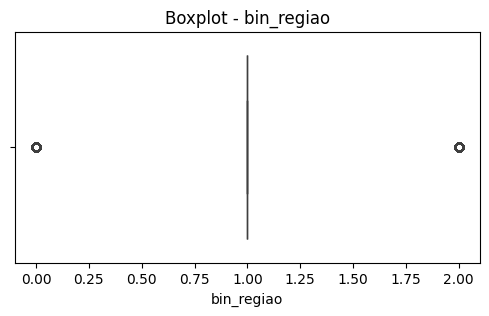

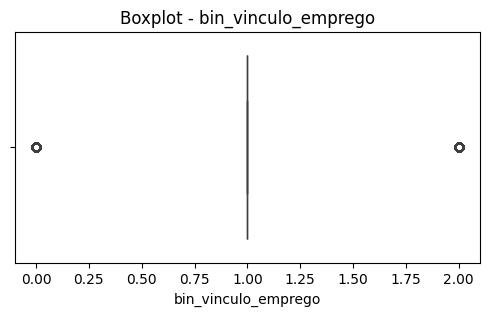

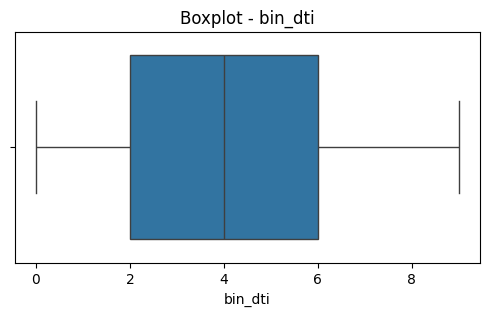

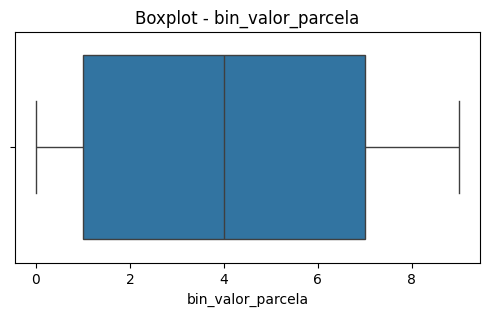

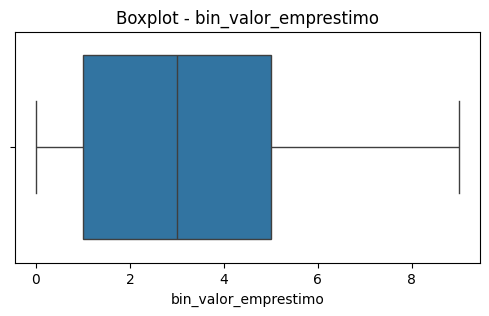

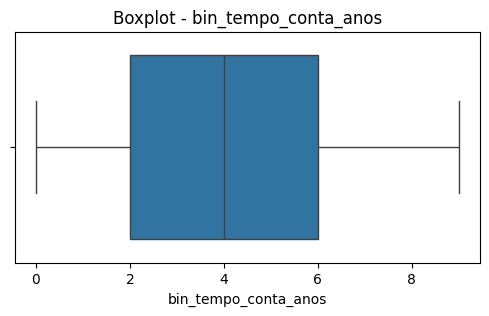

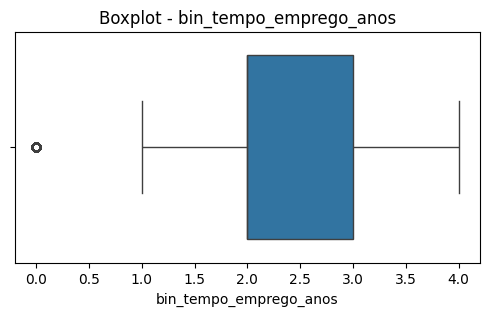

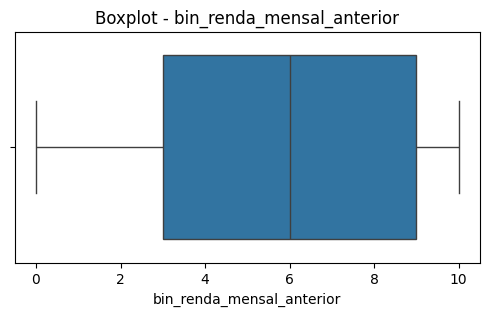

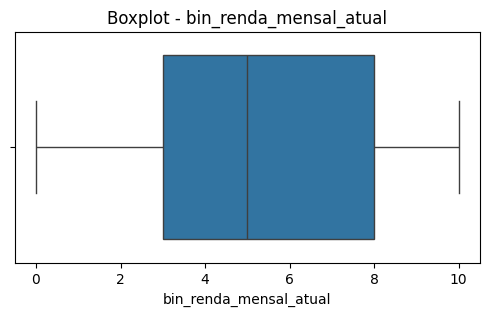

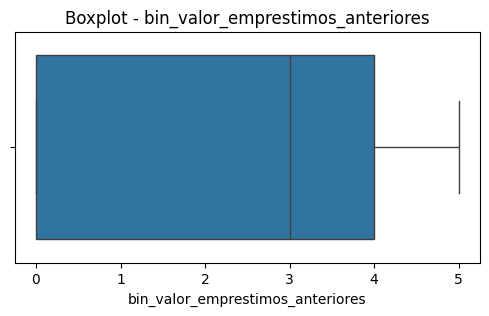

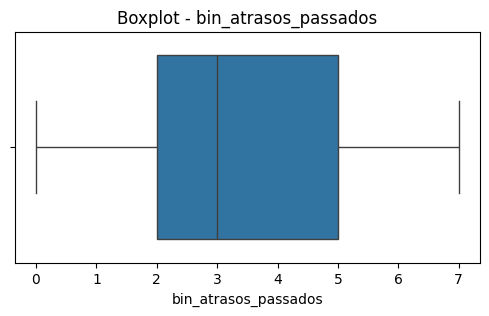

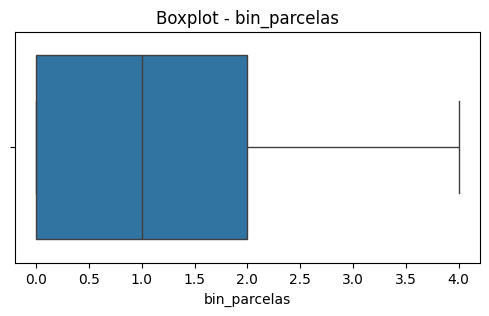

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleciona apenas colunas numéricas que começam com "bin_"
cols_bin = [
    col for col in df_label_bins.select_dtypes(include=[np.number]).columns
    if col.startswith("bin_")
]

# Boxplot para cada coluna filtrada
for col in cols_bin:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df_label_bins[col])
    plt.title(f"Boxplot - {col}")
    plt.show()


In [ ]:
import pandas as pd

def drop_colunas(df: pd.DataFrame, colunas: list):
    """
    Remove do DataFrame as colunas informadas em `colunas`.
    Retorna um novo DataFrame sem as colunas.
    """
    return df.drop(columns=colunas, errors="ignore")  # errors="ignore" evita erro se a coluna não existir

colunas_para_remover = cols_out

df_sem_colunas = drop_colunas(df_label_bins, colunas_para_remover)

display(df_sem_colunas)


,score_credito,taxa_juros_mensal,produto,setor,uf,canal,estado_civil,escolaridade,qtd_produtos_bancarios,usa_internet_banking,...,bin_dti,bin_valor_parcela,bin_valor_emprestimo,bin_tempo_conta_anos,bin_renda_mensal_anterior,bin_renda_mensal_atual,bin_valor_emprestimos_anteriores,bin_atrasos_passados,bin_parcelas,tag_etapa_modelagem
0,449,0.0400,4,4,6,1,1,0,3,1,...,4,4,5,3,3,4,3,6,2,0
1,585,0.0400,3,2,9,0,2,3,2,0,...,6,4,5,6,10,2,4,3,1,0
2,620,0.0359,4,4,7,0,3,1,1,1,...,6,1,2,7,8,0,3,5,1,0
3,690,0.0263,3,6,9,2,1,3,1,0,...,3,5,2,4,7,7,0,3,0,0
4,485,0.0381,4,2,2,2,0,1,4,1,...,6,4,5,8,10,2,5,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560536,770,0.0184,4,4,4,1,1,2,1,1,...,3,1,4,7,4,5,0,0,1,1
560537,612,0.0386,4,6,6,0,0,2,3,1,...,3,2,5,8,4,4,3,3,4,1
560538,535,0.0356,1,0,6,3,0,0,2,1,...,7,2,2,7,0,0,0,2,0,1
560539,823,0.0146,1,3,0,3,0,2,2,1,...,3,3,8,1,6,6,0,1,4,1


In [ ]:
# Base de desenvolvimento (baseline)
df_baseline_final = df_sem_colunas[df_sem_colunas["tag_etapa_modelagem"] == 0]

# Base de monitoramento
df_monitoramento_final = df_sem_colunas[df_sem_colunas["tag_etapa_modelagem"] == 1]

# Analisando necessidade de balanceamento (Conclusão: Não há necessidade)
display(df_baseline_final["inadimplente"].value_counts())
print(len(df_baseline_final))

# Analisando necessidade de balanceamento (Conclusão: Não há necessidade)
display(df_monitoramento_final["inadimplente"].value_counts())
print(len(df_monitoramento_final))

inadimplente
0    228134
1    109557
Name: count, dtype: int64

337691


inadimplente
0    150477
1     72373
Name: count, dtype: int64

222850


### Cluster Test

Agglomerative (Hierarchical) | clusters=4 | silhouette=0.132


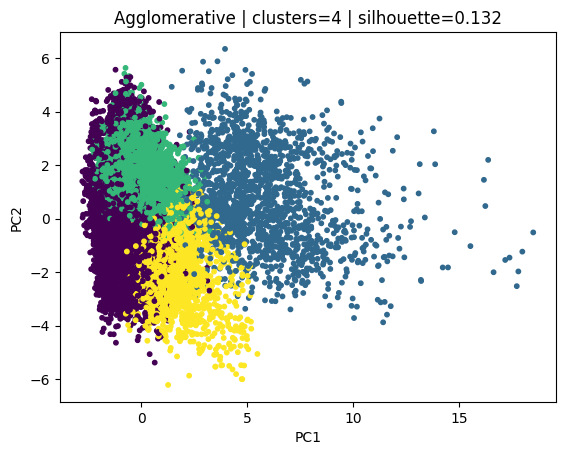

In [ ]:
## Cluster Test (leve) - Agglomerative (Hierarchical)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph

# ---------- helpers ----------
def safe_silhouette(X, labels):
    u = np.unique(labels)
    if len(u) >= 2:
        try:
            return silhouette_score(X, labels)
        except Exception:
            return np.nan
    return np.nan

# Amostra 20% da base (reduza p/ 0.10 se ainda pesar)
df_sample = df_top20.sample(frac=0.1, random_state=42)

# Só colunas numéricas
X = df_sample.select_dtypes(include=[np.number]).to_numpy()

# Padronizar
X_scaled = StandardScaler().fit_transform(X).astype("float32", copy=False)

# PCA mais enxuto
n_samples, n_features = X_scaled.shape
max_comps = min(n_samples, n_features)
ncomps = min(8, max_comps)   # <<<<< menor número de PCs

pca = PCA(n_components=ncomps, random_state=42)
X_pca = pca.fit_transform(X_scaled).astype("float32", copy=False)

# Grafo KNN esparso para reduzir custo do Agglomerative
# Ajuste n_neighbors conforme a densidade (10–20 costuma ir bem)
connectivity = kneighbors_graph(X_pca, n_neighbors=15, include_self=False, mode="distance")

# --- Agglomerative (Hierarchical) com conectividade esparsa ---
agg = AgglomerativeClustering(
    n_clusters=4,
    linkage="ward",          # ward exige distância euclidiana
    connectivity=connectivity
)
labels_agg = agg.fit_predict(X_pca)
sil_agg = safe_silhouette(X_pca, labels_agg)
print(f"Agglomerative (Hierarchical) | clusters=4 | silhouette={sil_agg:.3f}")

# ===== Plot =====
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=labels_agg)
plt.title(f"Agglomerative | clusters={len(np.unique(labels_agg))} | silhouette={sil_agg:.3f}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


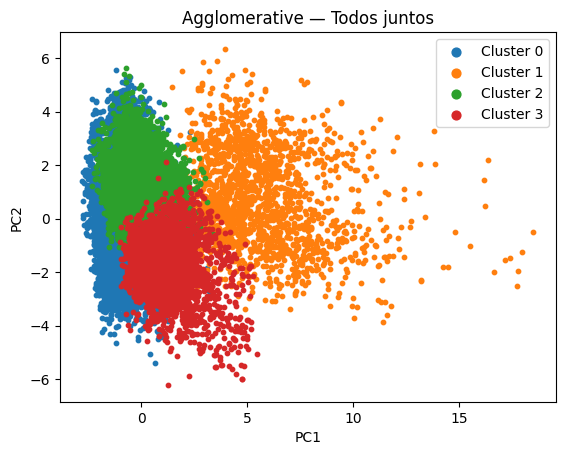

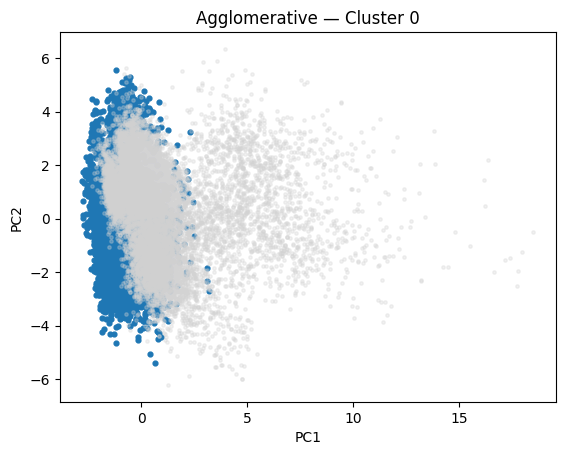

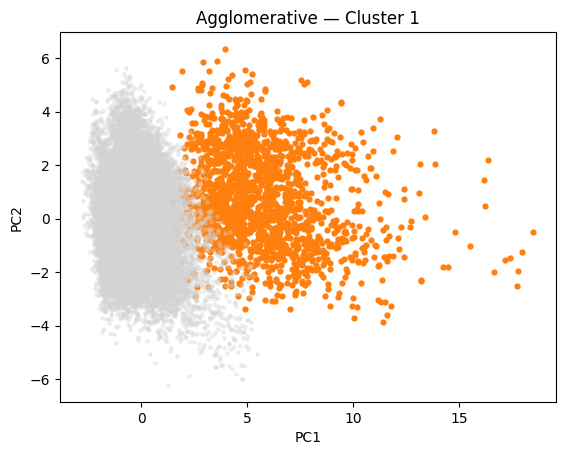

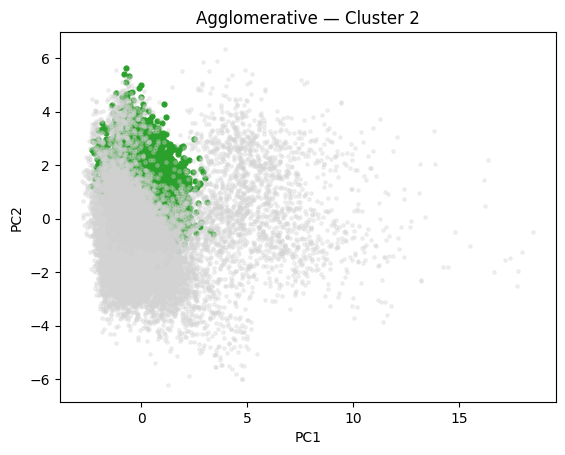

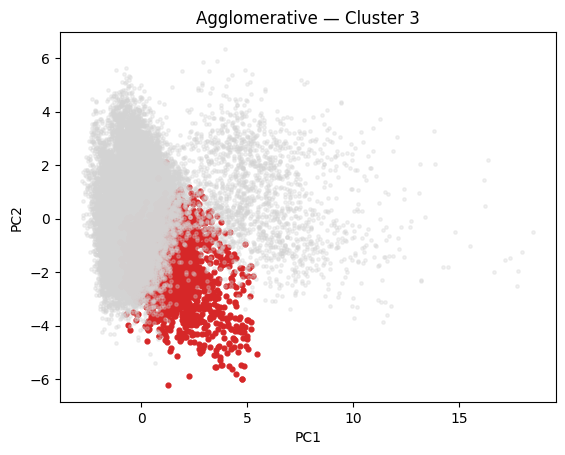

In [ ]:
## Cluster Test (leve) - Agglomerative (Hierarchical)
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import silhouette_score

def safe_silhouette(X, labels):
    u = np.unique(labels)
    if len(u) >= 2:
        try:
            return silhouette_score(X, labels)
        except Exception:
            return np.nan
    return np.nan

def plot_clusters_all_and_each(X_2d, labels, title_prefix="Clusters", outdir=None, max_plots=None):
    """
    X_2d: matriz (n_amostras x 2) — ex.: X_pca[:, :2]
    labels: array de rótulos (ex.: labels_agg)
    """
    if X_2d.shape[1] < 2:
        raise ValueError("X_2d precisa ter pelo menos 2 colunas (PC1 e PC2).")

    uniques = np.unique(labels)
    clusters_validos = [c for c in uniques if c != -1]
    tem_ruido = (-1 in uniques)

    # === Definir cores fixas por cluster ===
    cmap = plt.get_cmap("tab10")  # até 10 cores distintas, repete se >10
    colors = {c: cmap(i % 10) for i, c in enumerate(sorted(clusters_validos))}
    if tem_ruido:
        colors[-1] = "lightgray"  # ruído

    if outdir:
        os.makedirs(outdir, exist_ok=True)

    # === 1) Plot combinado (todos os clusters juntos) ===
    plt.figure()
    for c in uniques:
        mask = (labels == c)
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=10, c=[colors[c]], label=f"Cluster {c}")
    plt.legend(markerscale=2)
    plt.title(f"{title_prefix} — Todos juntos")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    if outdir:
        plt.savefig(os.path.join(outdir, f"{title_prefix}_todos.png"), dpi=120, bbox_inches="tight")
    plt.show()

    # === 2) Um gráfico por cluster ===
    clusters_to_plot = clusters_validos
    if (max_plots is not None) and (len(clusters_validos) > max_plots):
        clusters_to_plot = clusters_validos[:max_plots]

    for c in clusters_to_plot:
        mask = (labels == c)
        plt.figure()
        # cluster em foco
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=12, c=[colors[c]])
        # contexto (outros clusters apagados em cinza claro)
        plt.scatter(X_2d[~mask, 0], X_2d[~mask, 1], s=6, c="lightgray", alpha=0.3)

        plt.title(f"{title_prefix} — Cluster {c}")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        if outdir:
            plt.savefig(os.path.join(outdir, f"{title_prefix}_cluster_{c}.png"), dpi=120, bbox_inches="tight")
        plt.show()

    if (max_plots is not None) and (len(clusters_validos) > max_plots):
        print(f"Atenção: havia {len(clusters_validos)} clusters. Foram plotados apenas {max_plots} (defina max_plots=None para todos).")


# ===== Exemplo de uso com Agglomerative =====
# Usa os dois primeiros PCs para plot (PC1 e PC2)
plot_clusters_all_and_each(
    X_2d=X_pca[:, :2],
    labels=labels_agg,
    title_prefix="Agglomerative",
    outdir="plots_agg",     # ou None para não salvar
    max_plots=None          # defina um número (ex.: 12) se quiser limitar
)

# ===== Exemplo alternativo com KMeans =====
# plot_clusters_all_and_each(X_pca[:, :2], labels_km, title_prefix="KMeans", outdir="plots_km")


In [ ]:
## Cluster Test
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Amostra 20% da base
df_sample = df_sem_nan.sample(frac=0.1, random_state=42)  # 20%

# Só colunas numéricas
X = df_sample.select_dtypes(include=[np.number]).to_numpy()

# Padronizar
X_scaled = StandardScaler().fit_transform(X)

# Ajusta n_components dinamicamente
n_samples, n_features = X_scaled.shape
max_comps = min(n_samples, n_features)
ncomps = 10
# ncomps = min(10, max_comps)  # 30 ou o máximo permitido

# Reduzir para 30 componentes (ajuste se quiser menos/mais)
pca = PCA(n_components=ncomps, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- MiniBatchKMeans ---
mbk = MiniBatchKMeans(n_clusters=4, batch_size=4096, n_init=10, random_state=42)
labels_km = mbk.fit_predict(X_pca)
sil_km = silhouette_score(X_pca, labels_km)

print(f"KMeans (MiniBatch) | clusters=8 | silhouette={sil_km:.3f}")

# --- Função segura para silhouette (evita erro quando não há 2+ clusters) ---
def safe_silhouette(X, labels):
    u = np.unique(labels)
    # precisa de pelo menos 2 clusters distintos
    if len(u) >= 2:
        try:
            return silhouette_score(X, labels)
        except Exception:
            return np.nan
    return np.nan

# ======================
# 1) PLOT KMEANS
# ======================
km_sil = safe_silhouette(X_pca, labels_km)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=labels_km)
plt.title(f"KMeans | clusters={len(np.unique(labels_km))} | silhouette={km_sil:.3f}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

KeyboardInterrupt: 

### Model Selection - Sem Feature Enginnering

LR: 0.914 (0.004)
KNN: 0.761 (0.002)
CART: 0.771 (0.001)
NB: 0.895 (0.001)
Bag: 0.921 (0.001)
RF: 0.924 (0.001)
ET: 0.924 (0.001)
Ada: 0.922 (0.001)
GB: 0.927 (0.001)
Vot: 0.920 (0.001)

Ranking (métrica média CV):


,Modelo,Média,Desvio
0,GB,0.927365,0.000690
1,ET,0.924485,0.000833
2,RF,0.923816,0.000890
3,Ada,0.922153,0.001303
4,Bag,0.920789,0.000662
5,Vot,0.920488,0.000923
6,LR,0.913806,0.003803
7,NB,0.894830,0.000737
8,CART,0.771209,0.000982
9,KNN,0.760840,0.001771


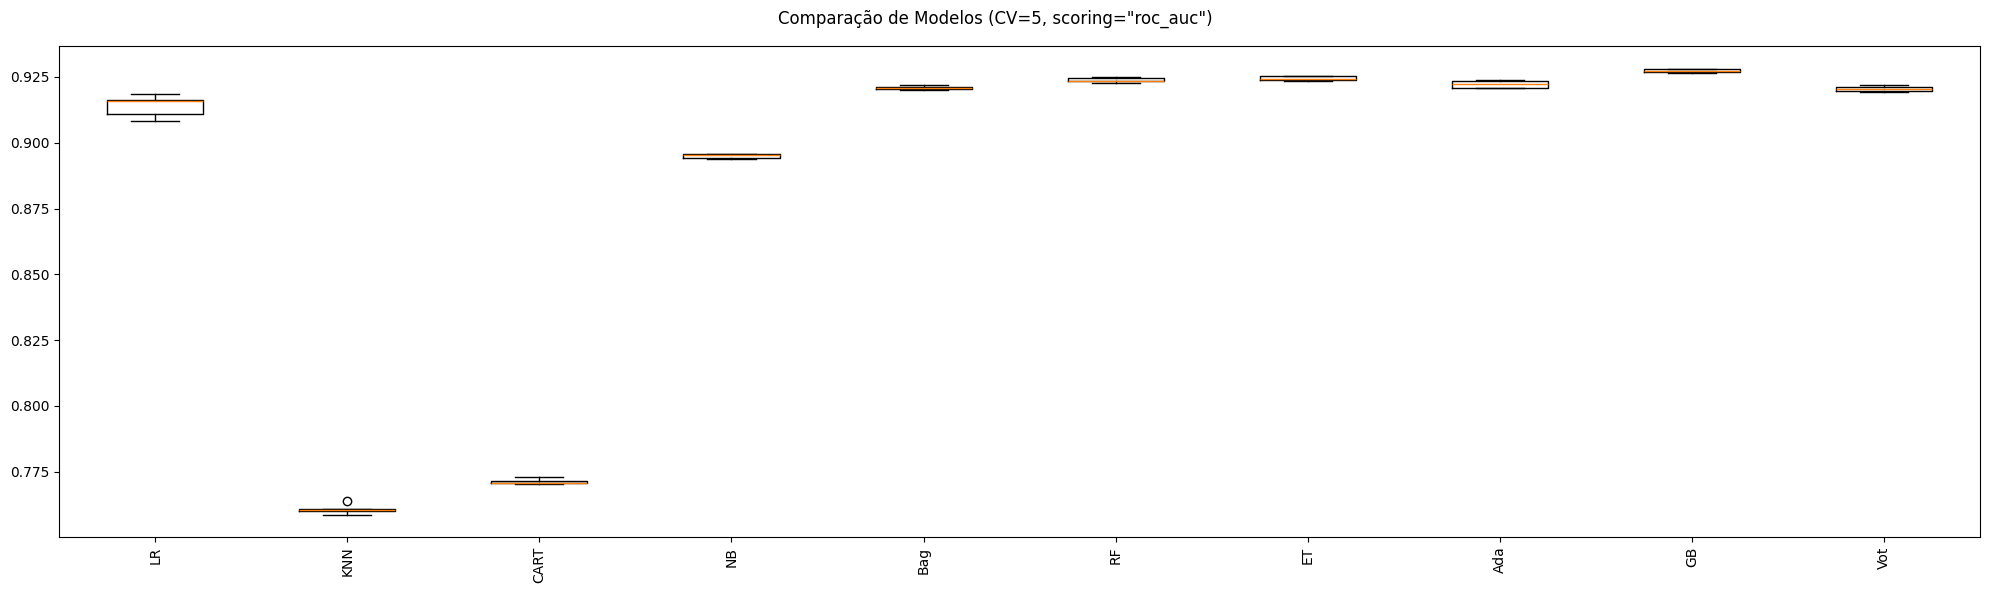

In [ ]:
# =======================
# Cross-Validation de Modelos (com split X/y)
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier
)

# -----------------------
# 1) Separa X e y
# -----------------------
target_col = "inadimplente"
X = df_top20_com_target.drop(columns=[target_col])
y = df_top20_com_target[target_col]

# -----------------------
# 2) Parâmetros principais
# -----------------------
RANDOM_STATE = 7
N_SPLITS = 5
N_ESTIMATORS = 200
MAX_FEATURES = "sqrt"
SCORING = "roc_auc"  # mude para "accuracy", "f1", etc.

# -----------------------
# 3) Definição dos modelos
# -----------------------
base_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

reg_log = ('LR',  LogisticRegression(max_iter=200, random_state=RANDOM_STATE))
knn     = ('KNN', KNeighborsClassifier())
cart    = ('CART', DecisionTreeClassifier(random_state=RANDOM_STATE))
nb      = ('NB',  GaussianNB())

bag     = ('Bag', BaggingClassifier(estimator=base_tree,
                                n_estimators=N_ESTIMATORS,
                                random_state=RANDOM_STATE))
rf      = ('RF',  RandomForestClassifier(n_estimators=N_ESTIMATORS,
                                         max_features=MAX_FEATURES,
                                         random_state=RANDOM_STATE,
                                         n_jobs=-1))
et      = ('ET',  ExtraTreesClassifier(n_estimators=N_ESTIMATORS,
                                       max_features=MAX_FEATURES,
                                       random_state=RANDOM_STATE,
                                       n_jobs=-1))
ada     = ('Ada', AdaBoostClassifier(n_estimators=N_ESTIMATORS,
                                     random_state=RANDOM_STATE))
gb      = ('GB',  GradientBoostingClassifier(random_state=RANDOM_STATE))

# Voting (soft)
bases_voting = [
    ('lr',  reg_log[1]),
    ('knn', knn[1]),
    ('nb',  nb[1]),
    ('rf',  rf[1]),
    ('et',  et[1]),
    ('ada', ada[1]),
    ('gb',  gb[1]),
]
vot = ('Voting', VotingClassifier(bases_voting, voting='soft', n_jobs=-1))

# -----------------------
# 4) Montagem dos pipelines
# -----------------------
pipelines = [
    ('LR',   Pipeline([reg_log])),
    ('KNN',  Pipeline([knn])),
    ('CART', Pipeline([cart])),
    ('NB',   Pipeline([nb])),
    ('Bag',  Pipeline([bag])),
    ('RF',   Pipeline([rf])),
    ('ET',   Pipeline([et])),
    ('Ada',  Pipeline([ada])),
    ('GB',   Pipeline([gb])),
    ('Vot',  Pipeline([vot])),
]

# -----------------------
# 5) Validação cruzada
# -----------------------
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

names, results, rows = [], [], []
for name, model in pipelines:
    scores = cross_val_score(model, X, y, cv=cv, scoring=SCORING, n_jobs=-1)
    results.append(scores)
    names.append(name)
    rows.append({"Modelo": name, "Média": scores.mean(), "Desvio": scores.std()})
    print(f"{name}: {scores.mean():.3f} ({scores.std():.3f})")

df_cv = pd.DataFrame(rows).sort_values(by="Média", ascending=False).reset_index(drop=True)
print("\nRanking (métrica média CV):")
display(df_cv)

# -----------------------
# 6) Boxplot comparativo
# -----------------------
plt.figure(figsize=(20,6))
plt.suptitle(f'Comparação de Modelos (CV={N_SPLITS}, scoring="{SCORING}")')
ax = plt.gca()
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.tight_layout()
plt.show()


LR: 0.911 (0.004)
RF: 0.920 (0.001)


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


ET: 0.920 (0.001)
Ada: 0.910 (0.002)
GB: 0.927 (0.001)


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Vot: 0.925 (0.001)

Ranking (métrica média CV):


,Modelo,Média,Desvio
0,GB,0.927305,0.000711
1,Vot,0.924948,0.000942
2,RF,0.920267,0.000677
3,ET,0.920214,0.000805
4,LR,0.911459,0.004351
5,Ada,0.910290,0.001554


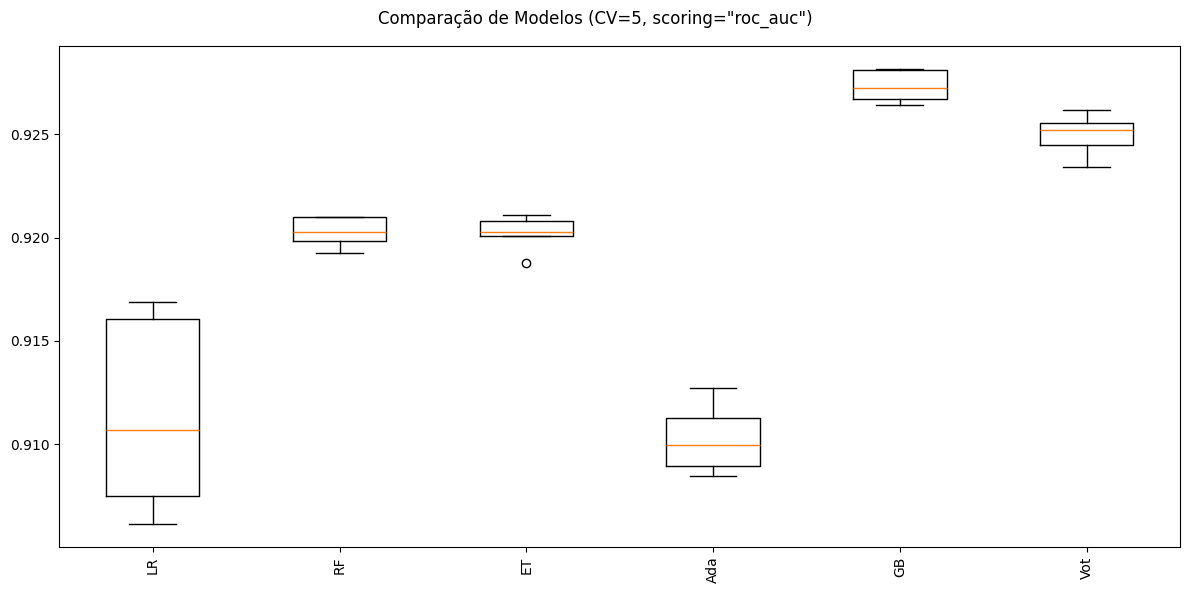

In [ ]:
# =======================
# Cross-Validation de Modelos (PD - modelos mais utilizados)
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier
)

# -----------------------
# 1) Separa X e y
# -----------------------
target_col = "inadimplente"  # ajuste se necessário
X = df_top20_com_target.drop(columns=[target_col])
y = df_top20_com_target[target_col]

# -----------------------
# 2) Parâmetros principais
# -----------------------
RANDOM_STATE = 7
N_SPLITS = 5
N_ESTIMATORS = 50
MAX_FEATURES = "sqrt"
SCORING = "roc_auc"

# -----------------------
# 3) Modelos principais para PD
# -----------------------
reg_log = ('LR',  LogisticRegression(max_iter=200, random_state=RANDOM_STATE))
rf      = ('RF',  RandomForestClassifier(n_estimators=N_ESTIMATORS,
                                         max_features=MAX_FEATURES,
                                         random_state=RANDOM_STATE,
                                         n_jobs=-1))
et      = ('ET',  ExtraTreesClassifier(n_estimators=N_ESTIMATORS,
                                       max_features=MAX_FEATURES,
                                       random_state=RANDOM_STATE,
                                       n_jobs=-1))
ada     = ('Ada', AdaBoostClassifier(n_estimators=N_ESTIMATORS,
                                     random_state=RANDOM_STATE))
gb      = ('GB',  GradientBoostingClassifier(random_state=RANDOM_STATE))

# Voting SOFT: média das probabilidades
voting_soft = ('Vot', VotingClassifier(
    estimators=[('lr', reg_log[1]), ('rf', rf[1]), ('gb', gb[1])],
    voting='soft',            # usa predict_proba()
    n_jobs=-1
))

pipelines = [
    ('LR',   Pipeline([reg_log])),
    ('RF',   Pipeline([rf])),
    ('ET',   Pipeline([et])),
    ('Ada',  Pipeline([ada])),
    ('GB',   Pipeline([gb])),
    ('Vot',  Pipeline([voting_soft])),  # <- ensemble
]

# -----------------------
# 4) Validação cruzada
# -----------------------
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

names, results, rows = [], [], []
for name, model in pipelines:
    scores = cross_val_score(model, X, y, cv=cv, scoring=SCORING, n_jobs=-1)
    results.append(scores)
    names.append(name)
    rows.append({"Modelo": name, "Média": scores.mean(), "Desvio": scores.std()})
    print(f"{name}: {scores.mean():.3f} ({scores.std():.3f})")

df_cv = pd.DataFrame(rows).sort_values(by="Média", ascending=False).reset_index(drop=True)
print("\nRanking (métrica média CV):")
display(df_cv)

# -----------------------
# 5) Boxplot comparativo
# -----------------------
plt.figure(figsize=(12,6))
plt.suptitle(f'Comparação de Modelos (CV={N_SPLITS}, scoring="{SCORING}")')
ax = plt.gca()
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.tight_layout()
plt.show()


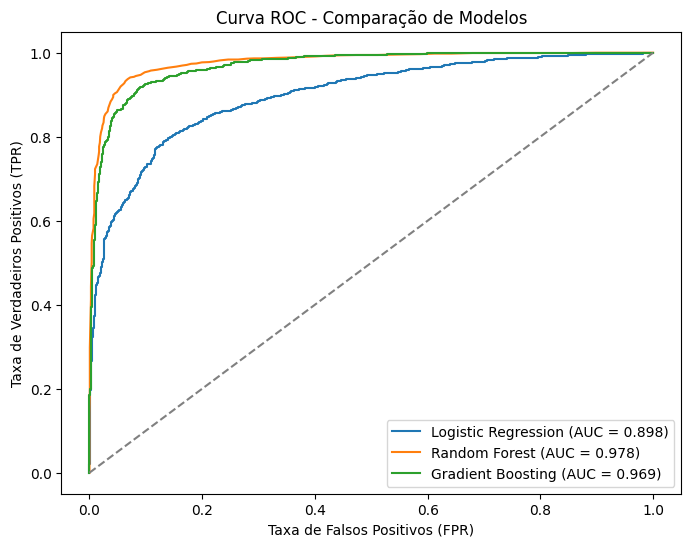

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

target_col = "inadimplente"  # ajuste se necessário
X = df_top20_com_target.drop(columns=[target_col])
y = df_top20_com_target[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 2. Modelos para comparar
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

plt.figure(figsize=(8,6))

# 3. Loop para treinar e plotar ROC
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_proba = modelo.predict_proba(X_test)[:,1]  # probabilidade da classe positiva
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{nome} (AUC = {roc_auc:.3f})")

# 4. Linha aleatória
plt.plot([0,1], [0,1], linestyle="--", color="gray")

plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Comparação de Modelos")
plt.legend()
plt.show()


== RANKING (por AUC-ROC no threshold que maximiza F1) ==
  modelo   AUC_ROC    AUC_PR        f1  precision    recall  accuracy
0     ET  0.982970  0.961158  0.902685   0.918089  0.887789  0.961333
1     RF  0.977672  0.949384  0.894281   0.941606  0.851485  0.959333
2     GB  0.972106  0.938549  0.868794   0.938697  0.808581  0.950667
3    Vot  0.966484  0.925943  0.860585   0.899281  0.825083  0.946000
4    Ada  0.920356  0.853887  0.768982   0.753165  0.785479  0.904667
5     LR  0.876344  0.791632  0.723810   0.697248  0.752475  0.884000


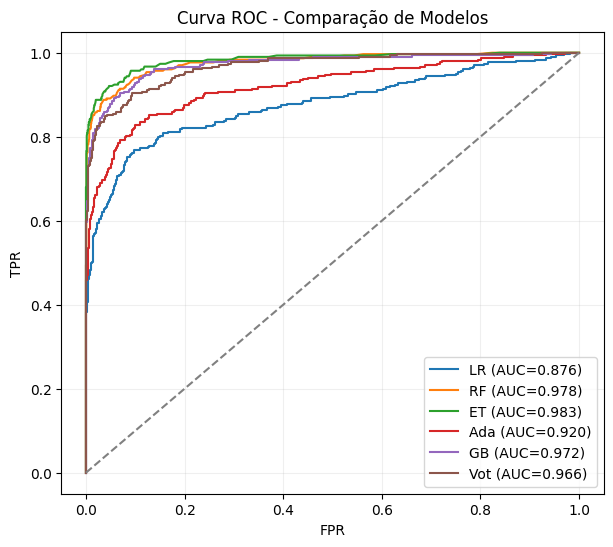

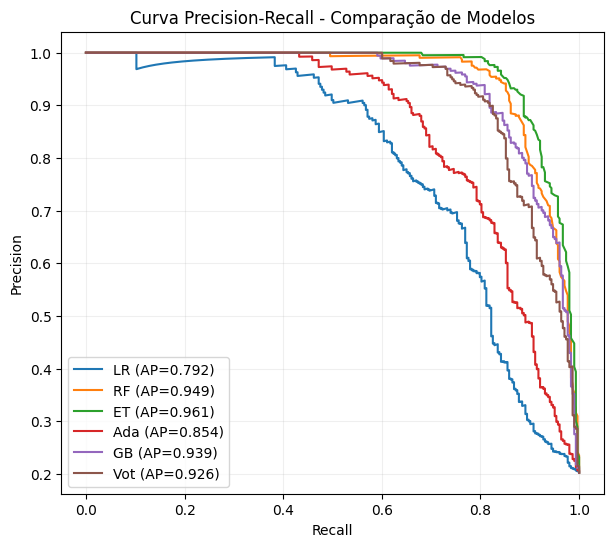


== AUC-ROC (CV=5) por modelo ==
LR: média=0.9029  std=0.0146
RF: média=0.9780  std=0.0074
ET: média=0.9817  std=0.0080
Ada: média=0.9382  std=0.0123
GB: média=0.9737  std=0.0091
Vot: média=0.9707  std=0.0089


In [ ]:
# ===========================
# COMPILAÇÃO DE MÉTRICAS & GRÁFICOS (SKLEARN)
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    AdaBoostClassifier, GradientBoostingClassifier,
    VotingClassifier
)

# =========================================================
# 1) PREPARE SEUS DADOS
# ---------------------------------------------------------
# Use X (features) e y (alvo binário). Abaixo deixo um exemplo sintético.
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=5000, n_features=30, n_informative=10, n_redundant=10,
    weights=[0.8, 0.2], random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# =========================================================
# 2) DEFINA OS MODELOS
# ---------------------------------------------------------
# LR usa padronização. Os demais ficam com hiperparâmetros default (ajuste depois).
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

rf  = RandomForestClassifier(n_estimators=400, random_state=42)
et  = ExtraTreesClassifier(n_estimators=400, random_state=42)
ada = AdaBoostClassifier(n_estimators=400, random_state=42)
gb  = GradientBoostingClassifier(random_state=42)

vot = VotingClassifier(
    estimators=[("lr", lr), ("rf", rf), ("gb", gb)],
    voting="soft"  # precisa de predict_proba
)

modelos = {
    "LR": lr,
    "RF": rf,
    "ET": et,
    "Ada": ada,
    "GB": gb,
    "Vot": vot
}

# =========================================================
# 3) FUNÇÕES AUXILIARES
# ---------------------------------------------------------
def best_threshold_by(criteria, y_true, y_proba):
    """
    Retorna o melhor limiar segundo:
      - 'youden' (maximiza TPR - FPR)
      - 'f1'     (maximiza F1)
    """
    fpr, tpr, th_roc = roc_curve(y_true, y_proba)
    if criteria == "youden":
        j = tpr - fpr
        thr = th_roc[np.argmax(j)]
        return float(thr)
    elif criteria == "f1":
        prec, rec, th_pr = precision_recall_curve(y_true, y_proba)
        f1_vals = 2 * (prec * rec) / (prec + rec + 1e-12)
        # precision_recall_curve retorna um ponto extra no fim; alinhar thresholds
        # thresholds tem len-1 de prec/rec
        thr = th_pr[np.argmax(f1_vals[:-1])]
        return float(thr)
    else:
        return 0.5

def eval_model(model, X_tr, y_tr, X_te, y_te, name):
    # Treina
    model.fit(X_tr, y_tr)

    # Probabilidades
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
    else:
        # fallback para decision_function
        y_score = model.decision_function(X_te)
        # escala para 0-1
        y_proba = (y_score - y_score.min()) / (y_score.max() - y_score.min() + 1e-12)

    # AUCs e curvas
    roc_auc = roc_auc_score(y_te, y_proba)
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    pr_prec, pr_rec, _ = precision_recall_curve(y_te, y_proba)
    ap = average_precision_score(y_te, y_proba)

    # Métricas com três limiares: 0.5, melhor Youden, melhor F1
    thresholds = {
        "0.50": 0.5,
        "Youden": best_threshold_by("youden", y_te, y_proba),
        "F1*": best_threshold_by("f1", y_te, y_proba)
    }

    rows = []
    cms  = {}

    for label_thr, thr in thresholds.items():
        y_pred = (y_proba >= thr).astype(int)
        acc = accuracy_score(y_te, y_pred)
        prec = precision_score(y_te, y_pred, zero_division=0)
        rec = recall_score(y_te, y_pred, zero_division=0)
        f1 = f1_score(y_te, y_pred, zero_division=0)
        rows.append({
            "modelo": name, "threshold": label_thr,
            "AUC_ROC": roc_auc, "AUC_PR": ap,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
        cms[label_thr] = confusion_matrix(y_te, y_pred)

    curves = {"fpr": fpr, "tpr": tpr, "pr_prec": pr_prec, "pr_rec": pr_rec}
    return pd.DataFrame(rows), cms, curves


# =========================================================
# 4) RODAR A AVALIAÇÃO
# ---------------------------------------------------------
tabela_list = []
cms_dict = {}
curvas = {}

for nome, mdl in modelos.items():
    dfm, cms, curves = eval_model(mdl, X_train, y_train, X_test, y_test, nome)
    tabela_list.append(dfm)
    cms_dict[nome] = cms
    curvas[nome] = curves

tabela_metricas = pd.concat(tabela_list, ignore_index=True)

# Ranking simples por AUC-ROC (threshold "F1*")
rank = (
    tabela_metricas[tabela_metricas["threshold"] == "F1*"]
    .sort_values(by=["AUC_ROC","AUC_PR","f1"], ascending=False)
    .reset_index(drop=True)
)

print("== RANKING (por AUC-ROC no threshold que maximiza F1) ==")
print(rank[["modelo","AUC_ROC","AUC_PR","f1","precision","recall","accuracy"]])

# =========================================================
# 5) GRÁFICOS (ROC e PRECISION-RECALL)
# ---------------------------------------------------------
plt.figure(figsize=(7,6))
for nome in modelos.keys():
    fpr = curvas[nome]["fpr"]
    tpr = curvas[nome]["tpr"]
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{nome} (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC - Comparação de Modelos")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

plt.figure(figsize=(7,6))
for nome in modelos.keys():
    pr_prec = curvas[nome]["pr_prec"]
    pr_rec  = curvas[nome]["pr_rec"]
    ap = average_precision_score(y_test,
                                 modelos[nome].predict_proba(X_test)[:,1]
                                 if hasattr(modelos[nome], "predict_proba")
                                 else modelos[nome].decision_function(X_test))
    # se decision_function: AP usa os scores (ok)
    plt.plot(pr_rec, pr_prec, label=f"{nome} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - Comparação de Modelos")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# =========================================================
# 6) OPÇÃO: VALIDAÇÃO CRUZADA RÁPIDA (apenas AUC-ROC)
# ---------------------------------------------------------
print("\n== AUC-ROC (CV=5) por modelo ==")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for nome, mdl in modelos.items():
    scores = cross_val_score(mdl, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
    print(f"{nome}: média={scores.mean():.4f}  std={scores.std():.4f}")


### Model Trainning - Sem Feature Enginnering

In [ ]:
# ====== GRADIENT BOOSTING (SEM PREPROCESS) | 60/40 ======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.ensemble import GradientBoostingClassifier

# -------------------------------------------------------
# 0) DEFINIR X,y A PARTIR DO SEU DATAFRAME
# -------------------------------------------------------
target_col = "inadimplente"  # ajuste se necessário
X = df_label_bins.drop(columns=[target_col])
y = df_label_bins[target_col]

# -------------------------------------------------------
# 1) SPLIT 60%/40% (estratificado)
# -------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.6, test_size=0.4, stratify=y, random_state=42
)

# -------------------------------------------------------
# 2) MODELO + ESPAÇO DE BUSCA
# -------------------------------------------------------
gb = GradientBoostingClassifier(random_state=42)

param_dist = {
    "n_estimators":      [100, 200, 300, 400],
    "learning_rate":     np.logspace(-2, 0, 8),   # 0.01 … 1.0
    "max_depth":         [2, 3, 4, 5],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf":  [1, 2, 5, 10],
    "subsample":         [0.6, 0.7, 0.8, 0.9, 1.0],
    "max_features":      ["sqrt", "log2", None]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# (opcional) pesos para lidar com desbalanceamento
use_balanced_weights = True
fit_kwargs = {}
if use_balanced_weights:
    sw = compute_sample_weight(class_weight="balanced", y=y_train)
    fit_kwargs["sample_weight"] = sw

# -------------------------------------------------------
# 3) TUNING (RandomizedSearchCV)
# -------------------------------------------------------
search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=40,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1
)
search.fit(X_train, y_train, **fit_kwargs)

print("\nMelhores hiperparâmetros:", search.best_params_)
print("AUC-ROC (CV, melhor):", round(search.best_score_, 4))

best_gb = search.best_estimator_

# -------------------------------------------------------
# 4) AVALIAÇÃO NO TESTE
# -------------------------------------------------------
y_proba = best_gb.predict_proba(X_test)[:, 1]  # GB tem predict_proba
auc_roc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
print(f"\nTESTE -> AUC-ROC={auc_roc:.4f} | AUC-PR(AP)={ap:.4f}")

# Curvas
fpr, tpr, thr_roc = roc_curve(y_test, y_proba)
prec, rec, thr_pr = precision_recall_curve(y_test, y_proba)

# Limiares úteis (Youden e melhor F1)
youden_thr = thr_roc[np.argmax(tpr - fpr)]
f1_vals = 2 * (prec * rec) / (prec + rec + 1e-12)
f1_thr = thr_pr[np.argmax(f1_vals[:-1])]

def report_at(thr, name):
    y_pred = (y_proba >= thr).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    p = precision_score(y_test, y_pred, zero_division=0)
    r = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    print(f"[{name}] thr={thr:.4f} | acc={acc:.3f} | prec={p:.3f} | rec={r:.3f} | f1={f1:.3f}")
    print("Matriz de confusão:\n", cm)

print("\n— Métricas por limiar —")
report_at(0.50, "T=0.50")
report_at(youden_thr, "Youden")
report_at(f1_thr, "F1*")

# -------------------------------------------------------
# 5) PLOTS (ROC e Precision-Recall)
# -------------------------------------------------------
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"GB (AUC={auc_roc:.3f})")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - Gradient Boosting")
plt.legend(); plt.grid(alpha=0.25); plt.show()

plt.figure(figsize=(7,6))
plt.plot(rec, prec, label=f"GB (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall - Gradient Boosting")
plt.legend(); plt.grid(alpha=0.25); plt.show()

# -------------------------------------------------------
# 6) IMPORTÂNCIA DE FEATURES (se X_train for DataFrame)
# -------------------------------------------------------
if hasattr(X_train, "columns"):
    importances = pd.Series(best_gb.feature_importances_, index=X_train.columns) \
                    .sort_values(ascending=False)
    ax = importances.head(25).iloc[::-1].plot.barh(figsize=(8,6))
    ax.set_title("GB - Importância de Features (Top 25)")
    ax.set_xlabel("Ganho (feature_importances_)")
    plt.tight_layout(); plt.show()

# -------------------------------------------------------
# 7) SALVAR MODELO
# -------------------------------------------------------
dump(best_gb, "gradient_boosting_model.joblib")
print("\nModelo salvo em: gradient_boosting_model.joblib")


Fitting 5 folds for each of 40 candidates, totalling 200 fits


KeyboardInterrupt: 


TESTE -> AUC-ROC=0.9276 | AUC-PR(AP)=0.8822

— Métricas por limiar —
[T=0.50] thr=0.5000 | acc=0.865 | prec=0.824 | rec=0.740 | f1=0.780
Matriz de confusão:
 [[84347  6907]
 [11392 32431]]
[Youden] thr=0.2971 | acc=0.846 | prec=0.726 | rec=0.847 | f1=0.782
Matriz de confusão:
 [[77233 14021]
 [ 6722 37101]]
[F1*] thr=0.3965 | acc=0.860 | prec=0.779 | rec=0.795 | f1=0.787
Matriz de confusão:
 [[81353  9901]
 [ 8994 34829]]


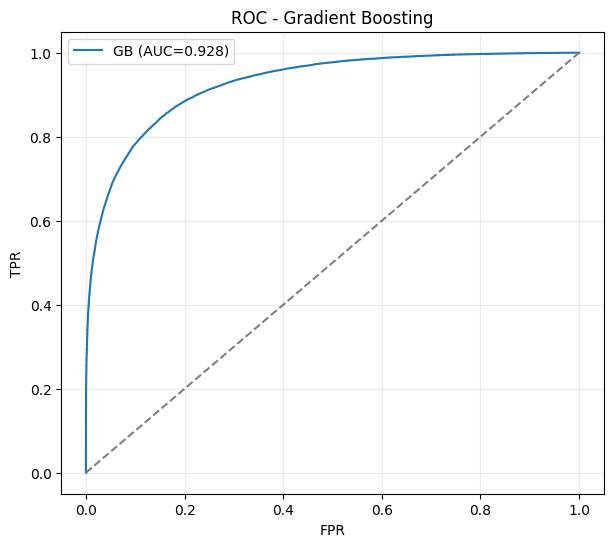

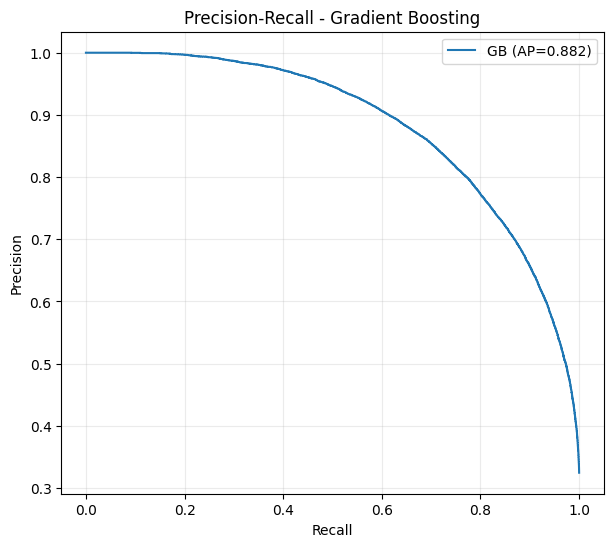

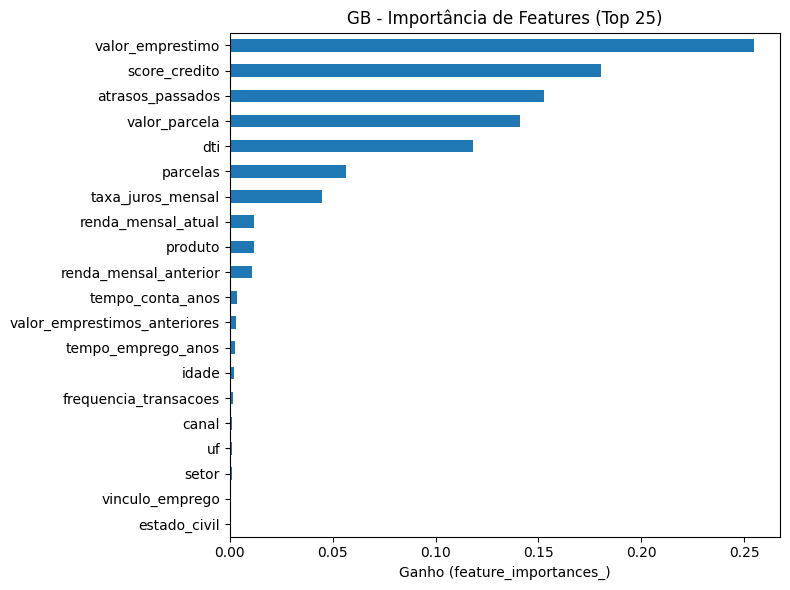

In [ ]:
# ====== GRADIENT BOOSTING (SEM TUNING & SEM BALANCEAMENTO) | 60/40 ======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.ensemble import GradientBoostingClassifier

# -------------------------------------------------------
# 0) DEFINIR X,y A PARTIR DO SEU DATAFRAME
# -------------------------------------------------------
target_col = "inadimplente"  # ajuste se necessário
X = df_top20_com_target.drop(columns=[target_col]).copy()
y = df_top20_com_target[target_col].copy()

# (opcional) cast leve para performance; não altera lógica
num_cols = X.select_dtypes(include=[np.number]).columns
X[num_cols] = X[num_cols].astype(np.float32)
y = y.astype(np.int8)

# (sanidade) se houver colunas não numéricas, pare — você disse que já pré-processa
non_num = X.columns[~X.columns.isin(num_cols)]
if len(non_num) > 0:
    raise ValueError(
        f"As colunas a seguir não são numéricas e devem ser codificadas antes: {list(non_num)}"
    )

# -------------------------------------------------------
# 1) SPLIT 60%/40% (estratificado)
# -------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.6, test_size=0.4, stratify=y
)

# -------------------------------------------------------
# 2) MODELO (configuração fixa, sem tuning, sem balanceamento)
# -------------------------------------------------------
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    min_samples_leaf=10,
    min_samples_split=20,
    subsample=0.8,
    max_features="sqrt",
    # Early stopping (remova estas 3 linhas se NÃO quiser)
    n_iter_no_change=10,
    validation_fraction=0.1,
    tol=1e-4
)

# Treino (sem sample_weight)
gb.fit(X_train, y_train)

# -------------------------------------------------------
# 3) AVALIAÇÃO NO TESTE
# -------------------------------------------------------
y_proba = gb.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
print(f"\nTESTE -> AUC-ROC={auc_roc:.4f} | AUC-PR(AP)={ap:.4f}")

# Curvas
fpr, tpr, thr_roc = roc_curve(y_test, y_proba)
prec, rec, thr_pr = precision_recall_curve(y_test, y_proba)

# Limiares (Youden e melhor F1)
youden_thr = thr_roc[np.argmax(tpr - fpr)]
f1_vals = 2 * (prec * rec) / (prec + rec + 1e-12)
f1_thr = thr_pr[np.argmax(f1_vals[:-1])]

def report_at(thr, name):
    y_pred = (y_proba >= thr).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    p = precision_score(y_test, y_pred, zero_division=0)
    r = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    print(f"[{name}] thr={thr:.4f} | acc={acc:.3f} | prec={p:.3f} | rec={r:.3f} | f1={f1:.3f}")
    print("Matriz de confusão:\n", cm)

print("\n— Métricas por limiar —")
report_at(0.50, "T=0.50")
report_at(youden_thr, "Youden")
report_at(f1_thr, "F1*")

# -------------------------------------------------------
# 4) PLOTS (ROC e Precision-Recall)
# -------------------------------------------------------
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"GB (AUC={auc_roc:.3f})")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - Gradient Boosting")
plt.legend(); plt.grid(alpha=0.25); plt.show()

plt.figure(figsize=(7,6))
plt.plot(rec, prec, label=f"GB (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall - Gradient Boosting")
plt.legend(); plt.grid(alpha=0.25); plt.show()

# -------------------------------------------------------
# 5) IMPORTÂNCIA DE FEATURES (se X_train tiver nomes)
# -------------------------------------------------------
if hasattr(X_train, "columns"):
    importances = pd.Series(gb.feature_importances_, index=X_train.columns) \
                    .sort_values(ascending=False)
    ax = importances.head(25).iloc[::-1].plot.barh(figsize=(8,6))
    ax.set_title("GB - Importância de Features (Top 25)")
    ax.set_xlabel("Ganho (feature_importances_)")
    plt.tight_layout(); plt.show()

# -------------------------------------------------------
# 6) SALVAR MODELO
# -------------------------------------------------------
# dump(gb, "gradient_boosting_model_leve.joblib")
# print("\nModelo salvo em: gradient_boosting_model_leve.joblib")


In [ ]:
# -------------------------------------------------------
# 3) AVALIAÇÃO NO TESTE (MÉTRICAS AMPLIADAS)
# -------------------------------------------------------
y_proba = gb.predict_proba(X_test)[:, 1]

# --- Métricas baseadas em probabilidade ---
auc_roc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)   # AUC-PR (Average Precision)
gini = 2 * auc_roc - 1                          # Gini

# Curvas ROC e PR
fpr, tpr, thr_roc = roc_curve(y_test, y_proba)
prec, rec, thr_pr = precision_recall_curve(y_test, y_proba)

# KS (equivalente ao máx(TPR - FPR))
ks = np.max(tpr - fpr)

print(f"\n=== MÉTRICAS PROBABILÍSTICAS (TESTE) ===")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUC-PR (AP): {ap:.4f}")
print(f"Gini: {gini:.4f}")
print(f"KS: {ks:.4f}")

# --- Limiares de decisão (thresholds) ---
# Youden (maximiza TPR - FPR) e melhor F1
youden_thr = thr_roc[np.argmax(tpr - fpr)]
f1_vals = 2 * (prec * rec) / (prec + rec + 1e-12)
f1_thr = thr_pr[np.argmax(f1_vals[:-1])]

def report_at(thr, name):
    y_pred = (y_proba >= thr).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    p = precision_score(y_test, y_pred, zero_division=0)
    r = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    print(f"\n[{name}] thr={thr:.4f}")
    print(f"accuracy={acc:.4f} | precision={p:.4f} | recall={r:.4f} | f1={f1:.4f}")
    print("Matriz de confusão (linhas=verdadeiro, colunas=previsto):\n", cm)

print("\n— Métricas por limiar —")
report_at(0.50, "T=0.50")
report_at(youden_thr, "Youden (max TPR-FPR)")
report_at(f1_thr, "F1* (máx F1)")



=== MÉTRICAS PROBABILÍSTICAS (TESTE) ===
AUC-ROC: 0.9276
AUC-PR (AP): 0.8822
Gini: 0.8552
KS: 0.6930

— Métricas por limiar —

[T=0.50] thr=0.5000
accuracy=0.8645 | precision=0.8244 | recall=0.7400 | f1=0.7800
Matriz de confusão (linhas=verdadeiro, colunas=previsto):
 [[84347  6907]
 [11392 32431]]

[Youden (max TPR-FPR)] thr=0.2971
accuracy=0.8464 | precision=0.7257 | recall=0.8466 | f1=0.7815
Matriz de confusão (linhas=verdadeiro, colunas=previsto):
 [[77233 14021]
 [ 6722 37101]]

[F1* (máx F1)] thr=0.3965
accuracy=0.8601 | precision=0.7786 | recall=0.7948 | f1=0.7866
Matriz de confusão (linhas=verdadeiro, colunas=previsto):
 [[81353  9901]
 [ 8994 34829]]


### Model Trainning - Com Feature Enginnering


TESTE -> AUC-ROC=0.9124 | AUC-PR(AP)=0.8566

— Métricas por limiar —
[T=0.50] thr=0.5000 | acc=0.847 | prec=0.798 | rec=0.708 | f1=0.750
Matriz de confusão:
 [[83417  7837]
 [12804 31019]]
[Youden] thr=0.3273 | acc=0.832 | prec=0.709 | rec=0.817 | f1=0.759
Matriz de confusão:
 [[76551 14703]
 [ 8022 35801]]
[F1*] thr=0.3599 | acc=0.837 | prec=0.727 | rec=0.798 | f1=0.761
Matriz de confusão:
 [[78112 13142]
 [ 8862 34961]]


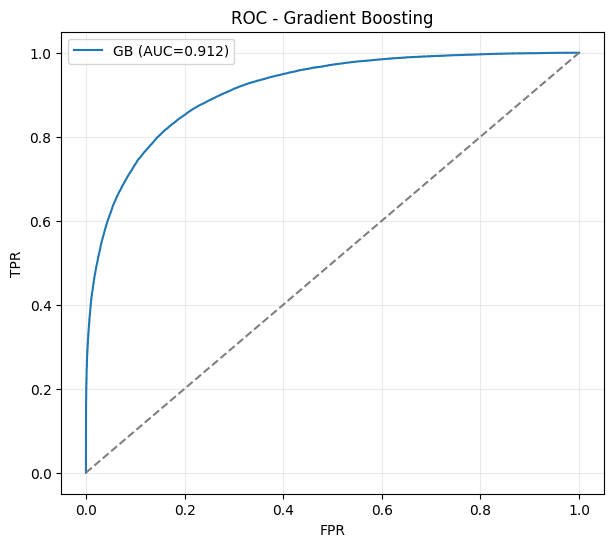

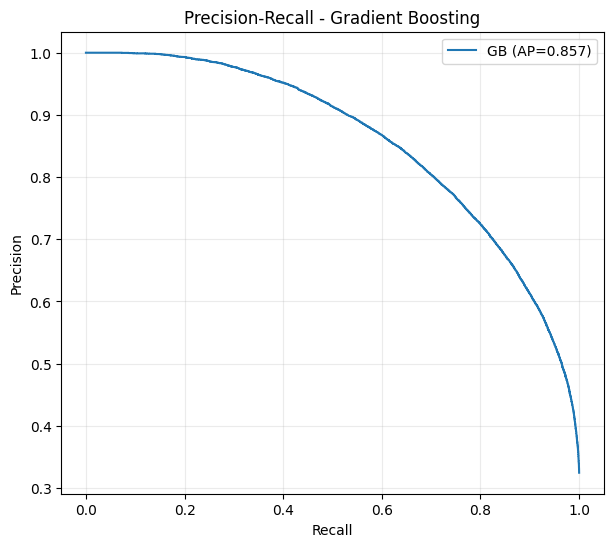

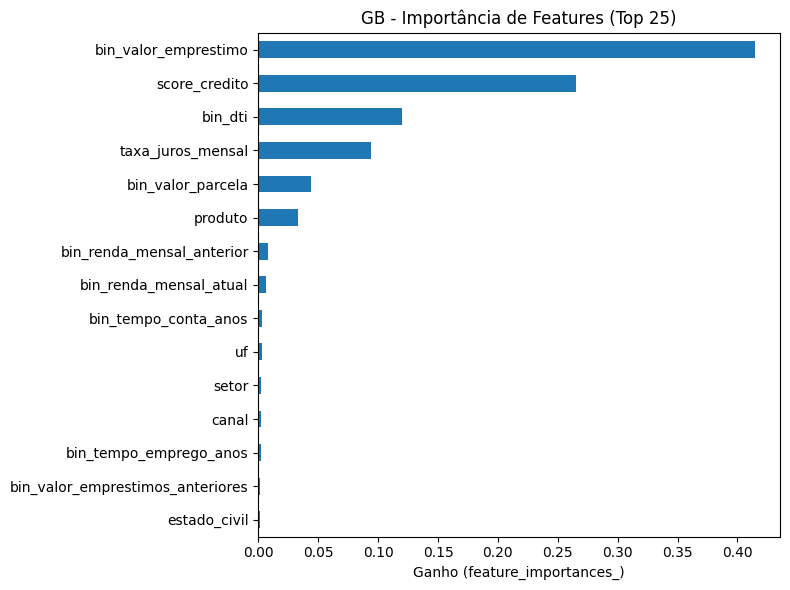

In [ ]:
# ====== GRADIENT BOOSTING (SEM TUNING & SEM BALANCEAMENTO) | 60/40 ======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.ensemble import GradientBoostingClassifier

# -------------------------------------------------------
# 0) DEFINIR X,y A PARTIR DO SEU DATAFRAME
# -------------------------------------------------------
target_col = "inadimplente"  # ajuste se necessário
X = df_final.drop(columns=[target_col]).copy()
y = df_final[target_col].copy()

# (opcional) cast leve para performance; não altera lógica
num_cols = X.select_dtypes(include=[np.number]).columns
X[num_cols] = X[num_cols].astype(np.float32)
y = y.astype(np.int8)

# (sanidade) se houver colunas não numéricas, pare — você disse que já pré-processa
non_num = X.columns[~X.columns.isin(num_cols)]
if len(non_num) > 0:
    raise ValueError(
        f"As colunas a seguir não são numéricas e devem ser codificadas antes: {list(non_num)}"
    )

# -------------------------------------------------------
# 1) SPLIT 60%/40% (estratificado)
# -------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.6, test_size=0.4, stratify=y
)

# -------------------------------------------------------
# 2) MODELO (configuração fixa, sem tuning, sem balanceamento)
# -------------------------------------------------------
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    min_samples_leaf=10,
    min_samples_split=20,
    subsample=0.8,
    max_features="sqrt",
    # Early stopping (remova estas 3 linhas se NÃO quiser)
    n_iter_no_change=10,
    validation_fraction=0.1,
    tol=1e-4
)

# Treino (sem sample_weight)
gb.fit(X_train, y_train)

# -------------------------------------------------------
# 3) AVALIAÇÃO NO TESTE
# -------------------------------------------------------
y_proba = gb.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
print(f"\nTESTE -> AUC-ROC={auc_roc:.4f} | AUC-PR(AP)={ap:.4f}")

# Curvas
fpr, tpr, thr_roc = roc_curve(y_test, y_proba)
prec, rec, thr_pr = precision_recall_curve(y_test, y_proba)

# Limiares (Youden e melhor F1)
youden_thr = thr_roc[np.argmax(tpr - fpr)]
f1_vals = 2 * (prec * rec) / (prec + rec + 1e-12)
f1_thr = thr_pr[np.argmax(f1_vals[:-1])]

def report_at(thr, name):
    y_pred = (y_proba >= thr).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    p = precision_score(y_test, y_pred, zero_division=0)
    r = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    print(f"[{name}] thr={thr:.4f} | acc={acc:.3f} | prec={p:.3f} | rec={r:.3f} | f1={f1:.3f}")
    print("Matriz de confusão:\n", cm)

print("\n— Métricas por limiar —")
report_at(0.50, "T=0.50")
report_at(youden_thr, "Youden")
report_at(f1_thr, "F1*")

# -------------------------------------------------------
# 4) PLOTS (ROC e Precision-Recall)
# -------------------------------------------------------
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"GB (AUC={auc_roc:.3f})")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - Gradient Boosting")
plt.legend(); plt.grid(alpha=0.25); plt.show()

plt.figure(figsize=(7,6))
plt.plot(rec, prec, label=f"GB (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall - Gradient Boosting")
plt.legend(); plt.grid(alpha=0.25); plt.show()

# -------------------------------------------------------
# 5) IMPORTÂNCIA DE FEATURES (se X_train tiver nomes)
# -------------------------------------------------------
if hasattr(X_train, "columns"):
    importances = pd.Series(gb.feature_importances_, index=X_train.columns) \
                    .sort_values(ascending=False)
    ax = importances.head(25).iloc[::-1].plot.barh(figsize=(8,6))
    ax.set_title("GB - Importância de Features (Top 25)")
    ax.set_xlabel("Ganho (feature_importances_)")
    plt.tight_layout(); plt.show()

# -------------------------------------------------------
# 6) SALVAR MODELO
# -------------------------------------------------------
# dump(gb, "gradient_boosting_model_leve.joblib")
# print("\nModelo salvo em: gradient_boosting_model_leve.joblib")


In [ ]:
# -------------------------------------------------------
# 3) AVALIAÇÃO NO TESTE (MÉTRICAS AMPLIADAS)
# -------------------------------------------------------
y_proba = gb.predict_proba(X_test)[:, 1]

# --- Métricas baseadas em probabilidade ---
auc_roc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)   # AUC-PR (Average Precision)
gini = 2 * auc_roc - 1                          # Gini

# Curvas ROC e PR
fpr, tpr, thr_roc = roc_curve(y_test, y_proba)
prec, rec, thr_pr = precision_recall_curve(y_test, y_proba)

# KS (equivalente ao máx(TPR - FPR))
ks = np.max(tpr - fpr)

print(f"\n=== MÉTRICAS PROBABILÍSTICAS (TESTE) ===")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUC-PR (AP): {ap:.4f}")
print(f"Gini: {gini:.4f}")
print(f"KS: {ks:.4f}")

# --- Limiares de decisão (thresholds) ---
# Youden (maximiza TPR - FPR) e melhor F1
youden_thr = thr_roc[np.argmax(tpr - fpr)]
f1_vals = 2 * (prec * rec) / (prec + rec + 1e-12)
f1_thr = thr_pr[np.argmax(f1_vals[:-1])]

def report_at(thr, name):
    y_pred = (y_proba >= thr).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    p = precision_score(y_test, y_pred, zero_division=0)
    r = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    print(f"\n[{name}] thr={thr:.4f}")
    print(f"accuracy={acc:.4f} | precision={p:.4f} | recall={r:.4f} | f1={f1:.4f}")
    print("Matriz de confusão (linhas=verdadeiro, colunas=previsto):\n", cm)

print("\n— Métricas por limiar —")
report_at(0.50, "T=0.50")
report_at(youden_thr, "Youden (max TPR-FPR)")
report_at(f1_thr, "F1* (máx F1)")



=== MÉTRICAS PROBABILÍSTICAS (TESTE) ===
AUC-ROC: 0.9124
AUC-PR (AP): 0.8566
Gini: 0.8249
KS: 0.6558

— Métricas por limiar —

[T=0.50] thr=0.5000
accuracy=0.8472 | precision=0.7983 | recall=0.7078 | f1=0.7503
Matriz de confusão (linhas=verdadeiro, colunas=previsto):
 [[83417  7837]
 [12804 31019]]

[Youden (max TPR-FPR)] thr=0.3273
accuracy=0.8318 | precision=0.7089 | recall=0.8169 | f1=0.7591
Matriz de confusão (linhas=verdadeiro, colunas=previsto):
 [[76551 14703]
 [ 8022 35801]]

[F1* (máx F1)] thr=0.3599
accuracy=0.8371 | precision=0.7268 | recall=0.7978 | f1=0.7606
Matriz de confusão (linhas=verdadeiro, colunas=previsto):
 [[78112 13142]
 [ 8862 34961]]


## Outras Coisas

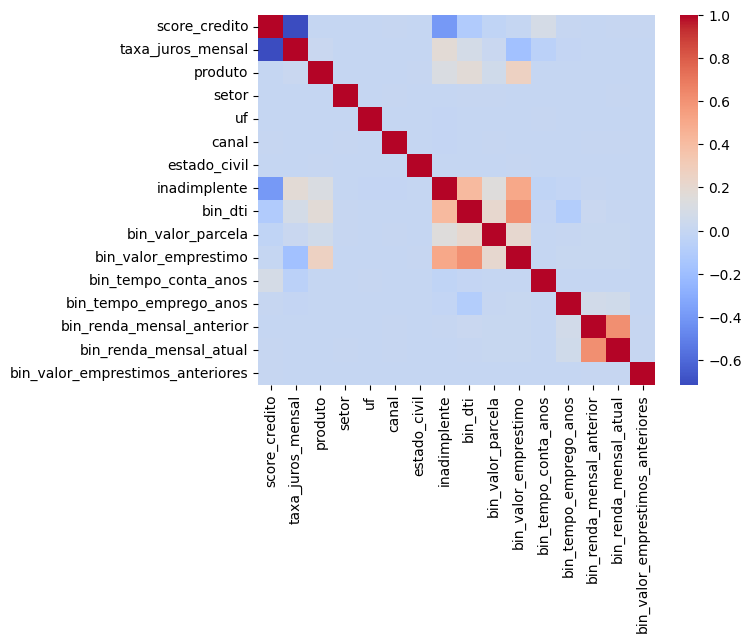

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 1. Calcular a matriz de correlação usando Pandas
matriz_correlacao = df_final.corr()
#print("Matriz de Correlação (Pandas):\n", matriz_correlacao)

# 2. Visualizar a matriz de correlação com Seaborn
sns.heatmap(matriz_correlacao, annot=False, cmap='coolwarm')
plt.show()

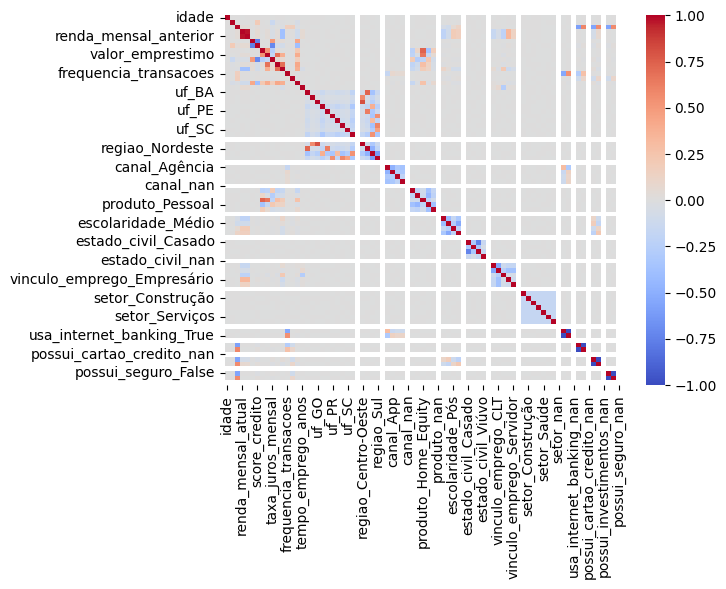

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 1. Calcular a matriz de correlação usando Pandas
matriz_correlacao = df_one_hot.corr()
#print("Matriz de Correlação (Pandas):\n", matriz_correlacao)

# 2. Visualizar a matriz de correlação com Seaborn
sns.heatmap(matriz_correlacao, annot=False, cmap='coolwarm')
plt.show()

usa_internet_banking_False   usa_internet_banking_True    -1.000000
possui_cartao_credito_False  possui_cartao_credito_True   -1.000000
possui_investimentos_False   possui_investimentos_True    -1.000000
possui_seguro_False          possui_seguro_True           -1.000000
renda_mensal_atual           renda_mensal_anterior         0.974032
                                                             ...   
dti                          produto_Cartão               -0.153812
renda_mensal_atual           vinculo_emprego_Autônomo     -0.152024
renda_mensal_anterior        vinculo_emprego_Autônomo     -0.151742
valor_emprestimo             produto_Pessoal              -0.150361
uf_SC                        uf_SP                        -0.150040
Length: 159, dtype: float64


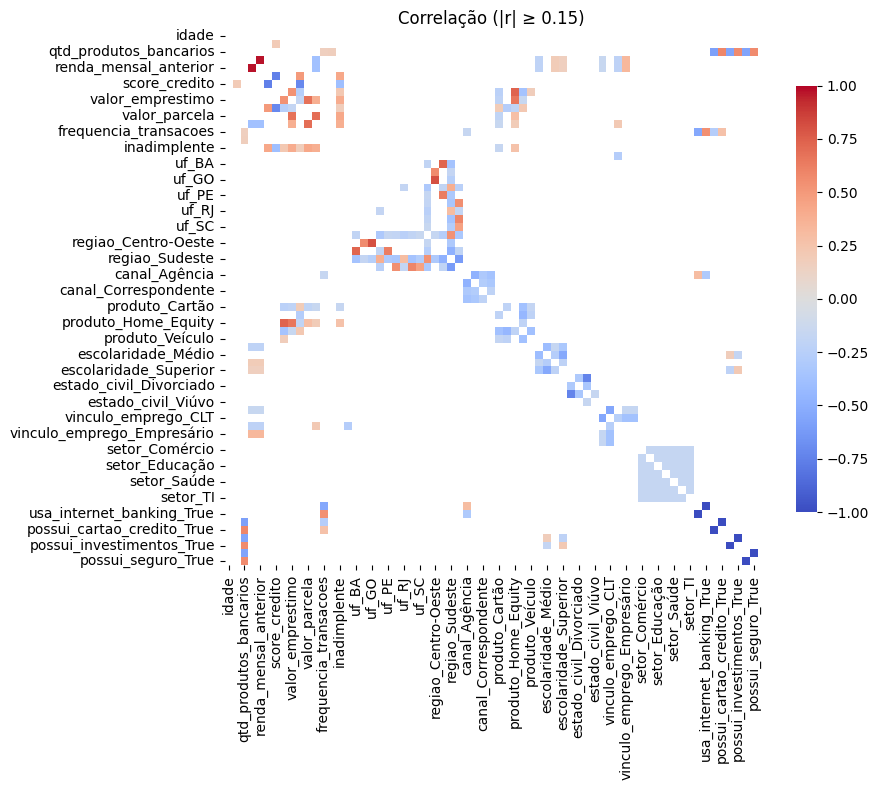

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

thr = 0.15

# 1) Correlação
corr = df_one_hot.corr(numeric_only=True)

# 2) PARES com |r| >= thr (upper triangle para evitar duplicados)
ut = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
pares_filtrados = ut.stack().loc[lambda s: s.abs() >= thr].sort_values(key=lambda s: s.abs(), ascending=False)
print(pares_filtrados)  # remove se não quiser listar

# 3) Para o heatmap: manter apenas colunas que têm ao menos um |r| >= thr
keep_cols = (corr.abs() >= thr).any(axis=1)
corr_f = corr.loc[keep_cols, keep_cols].copy()

if corr_f.empty:
    print(f"Não há pares com |r| >= {thr}.")
else:
    # opcional: esconder a diagonal
    np.fill_diagonal(corr_f.values, np.nan)
    # mascarar células abaixo do limiar
    mask = corr_f.abs() < thr

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_f, mask=mask, cmap='coolwarm', center=0, vmin=-1, vmax=1,
                annot=False, square=True, cbar_kws={'shrink': .8})
    plt.title(f'Correlação (|r| ≥ {thr})')
    plt.tight_layout()
    plt.show()


In [ ]:
# 3. Calcular correlação de Pearson e valor-p usando SciPy
corre_pearson, p_valor = pearsonr(df_one_hot['coluna1'], df_one_hot['coluna2'])
print(f"\nCorrelação de Pearson entre coluna1 e coluna2: {corre_pearson:.2f}")
print(f"Valor-p: {p_valor:.3f}")

KeyError: 'coluna1'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_xy(x, y, tipo='linha', titulo=None, xlabel=None, ylabel=None, eixo_data=False):
    fig, ax = plt.subplots(figsize=(10, 4))

    if tipo == 'linha':
        ax.plot(x, y)
    elif tipo == 'barra':
        ax.bar(x, y)
    else:  # 'dispersao'
        ax.scatter(x, y)

    if titulo: ax.set_title(titulo)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)

    if eixo_data:
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()

# uso:
# plot_xy(df['data'], df['volumetria'], tipo='linha', titulo='Volumetria diária', xlabel='Data', ylabel='Volumetria', eixo_data=True)


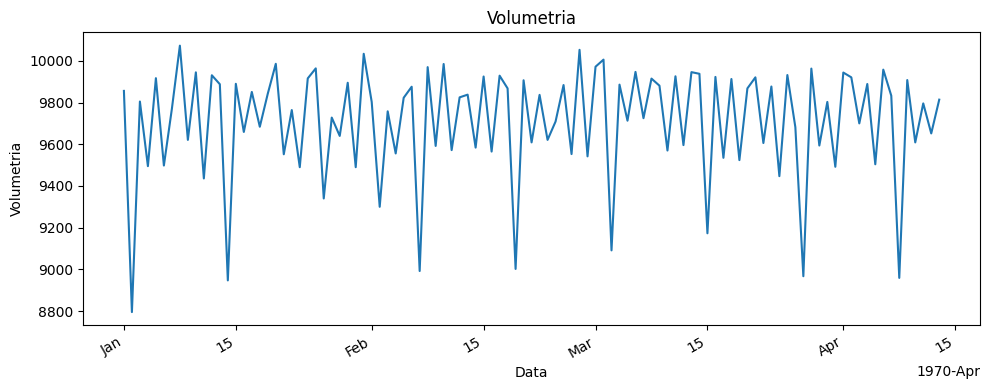

In [ ]:
plot_xy(contagem['safra'], contagem['qtd'], tipo='linha', titulo='Volumetria', xlabel='Data', ylabel='Volumetria', eixo_data=True)